# 3dasm Project

## Agenda
## Single Fidelity
- simulated data and experimental data separately
- different kernels, optimizers
## Multi Fidelity
- scikit-learn vs gpytorch
1. [Phase 1: Gaussian Process on Simulated Data only](#Phase-1:-Gaussian-Process-on-Simulated-Data-only)
2. [Training with Different Kernels: common Constant*RBF kernel with an optimizer fmin_1_bfgs_b](#Training-with-Different-Kernels:-common-Constant*RBF-kernel-with-an-optimizer-fmin_1_bfgs_b)
3. [Training with Different Kernels: ExpSineSquared with an optimizer fmin_1_bfgs_b](#Training-with-Different-Kernels:-ExpSineSquared-with-an-optimizer-fmin_1_bfgs_b)
4. [Training with Different Kernels: Matern with an optimizer fmin_1_bfgs_b](#Training-with-Different-Kernels:-Matern-with-an-optimizer-fmin_1_bfgs_b)
5. [Training with Different Kernels: common Constant*RBF kernel With No Optimizer](#Training-with-Different-Kernels:-common-Constant*RBF-kernel-With-No-Optimizer)
6. [Training with Different Kernels: ExpSineSquared with no optimizer](#Training-with-Different-Kernels:-ExpSineSquared-with-no-optimizer)
7. [Training with Different Kernels: Matern with no optimizer](#Training-with-Different-Kernels:-Matern-with-no-optimizer)
8. [Phase 1.5: Gaussian Process on Experimental Data Only](#Phase-1.5:-Gaussian-Process-on-Experimental-Data-Only)
9. [Training with Different kernels: common Constant*RBF kernel with an optimizer fmin_1_bfgs_b](#Training-with-Different-kernels:-common-Constant*RBF-kernel-with-an-optimizer-fmin_1_bfgs_b)
10. [Training with Different Kernels: ExpSineSquared with an optimizer fmin_1_bfgs_b](#Training-with-Different-Kernels:-ExpSineSquared-with-an-optimizer-fmin_1_bfgs_b)
11. [Training with Different Kernels: Matern with an optimizer fmin_1_bfgs_b](#Training-with-Different-Kernels:-Matern-with-an-optimizer-fmin_1_bfgs_b)
12. [Phase 2: Training with Simulation Data and Testing with Experimental Data](#Phase-2:-Training-with-Simulation-Data-and-Testing-with-Experimental-Data)
13. [Constant Kernel and  f_min optimizer](#Constant-Kernel-and-f_min-optimizer)
14. [Matern kernel with no optimizer](#Matern-kernel-with-no-optimizer)
15. [Phase 3: Multi-fidelity Gaussian Process](#Phase-3:-Multi-fidelity-Gaussian-Process)

### Importing necessary packages

In [6]:
import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math
import pandas as pd

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel, WhiteKernel
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

In [8]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        } # using this property entry for nice plotting labels

<a id='Phase 1: Gaussian Process on Simulated Data only'></a>

## Phase 1: Gaussian Process on Simulated Data only

In [29]:
# import simulated data for the specific shear modulus and viscosity corresponding to the experimental data, pre-processing in matlab (including scaling)
sim_df = pd.read_csv("../less_points_Simulation_Data_0.05_13900.csv") # read pandas DataFrame
print("Show the simulated DataFrame used for training data:\n", sim_df)

Show the simulated DataFrame used for training data:
             0         1
0    0.075682  0.995894
1    0.181336  0.977851
2    0.286990  0.944549
3    0.378912  0.901576
4    0.453920  0.855101
..        ...       ...
464  4.782890  0.157443
465  4.830016  0.156129
466  4.877141  0.154620
467  4.924266  0.153483
468  4.971392  0.153081

[469 rows x 2 columns]


In [30]:
Data_x_sim = sim_df.iloc[:,0] # select the input values from the dataframe into Data_x
Data_y_sim = sim_df.iloc[:,1] # select the output values from the dataframe into Data_y
print("Data_x is:\n",Data_x_sim)
print("\nData_y is:\n",Data_y_sim)
#Note about data quality: don't need to scale as the data was already normalized 
##so that t is in (0,5) and R is in (0,1) and preprocessed such that data is nondimensionalized

Data_x is:
 0      0.075682
1      0.181336
2      0.286990
3      0.378912
4      0.453920
         ...   
464    4.782890
465    4.830016
466    4.877141
467    4.924266
468    4.971392
Name: 0, Length: 469, dtype: float64

Data_y is:
 0      0.995894
1      0.977851
2      0.944549
3      0.901576
4      0.855101
         ...   
464    0.157443
465    0.156129
466    0.154620
467    0.153483
468    0.153081
Name: 1, Length: 469, dtype: float64


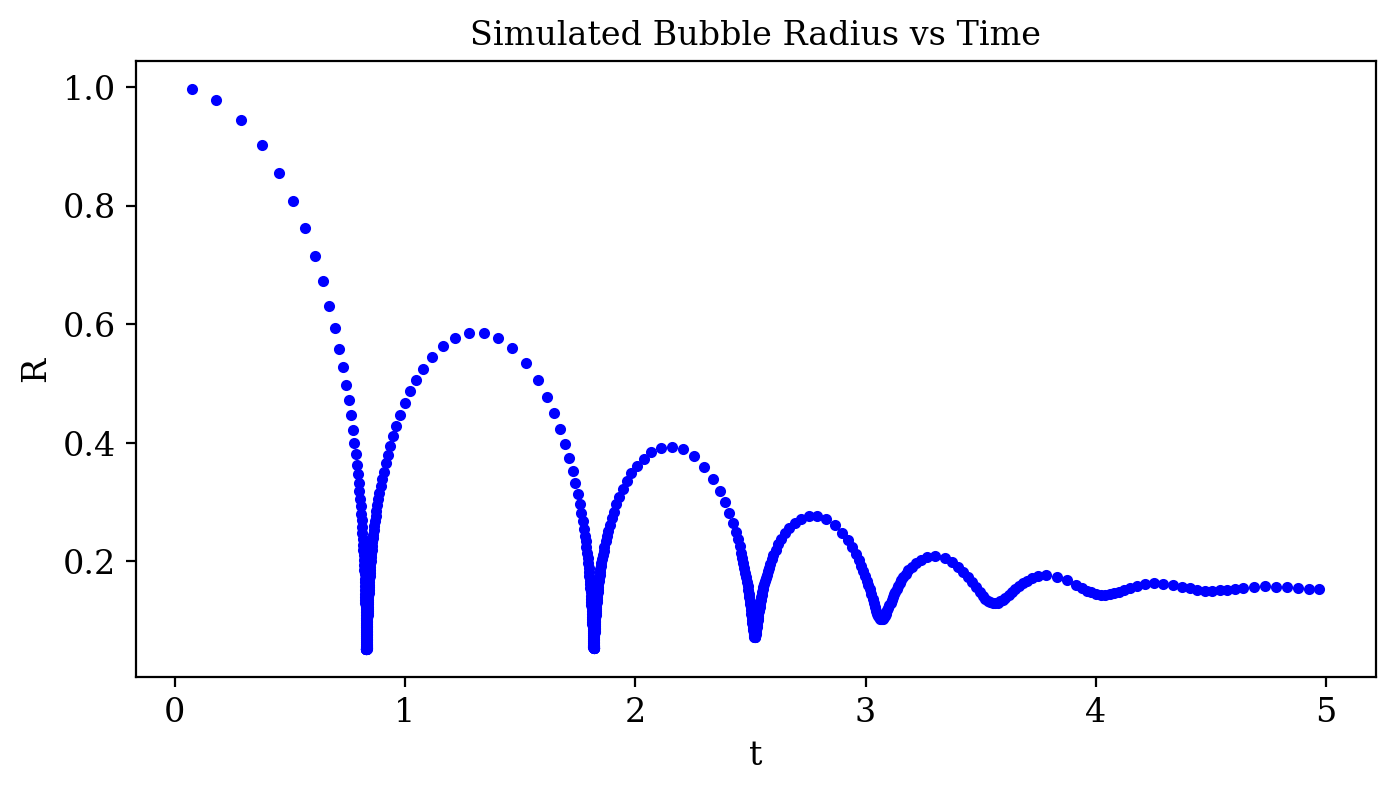

In [31]:
fig_sim_data, ax_sim_data = plt.subplots() # create a plot
ax_sim_data.plot(Data_x_sim, Data_y_sim, 'b.')
ax_sim_data.set_xlabel("t", font) # create x-axis label with font size 20
ax_sim_data.set_ylabel("R", font) # create y-axis label with font size 20
ax_sim_data.set_title("Simulated Bubble Radius vs Time", font); # create title with font size 20
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
plt.savefig("sim_data.png", bbox_inches="tight")
plt.show(fig_sim_data)

In [32]:
n_data = 50 # number of points in our dataset
testset_ratio_sim = 0.10 # ratio of test set points from the dataset

X_data_sim = np.reshape(Data_x_sim,(-1,1)) # a 2D array that scikit-learn likes
Y_data_sim = np.reshape(Data_y_sim,(-1, 1))

seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

# Let's split into 10% training points and the rest for testing:
X_train_sim, X_test_sim, y_train_sim, y_test_sim = train_test_split(X_data_sim,
                                    Data_y_sim, test_size=testset_ratio_sim,
                                    random_state=seed)

x_train_sim = X_train_sim.ravel() # just for plotting later
x_test_sim = X_test_sim.ravel() # just for plotting later

#print("Here's a print of X_train:\n", X_train_sim)

In [33]:
# Define points used for plotting
n_max_sim = np.max(X_data_sim)
n_min_sim = np.min(X_data_sim)
n_plot_sim = 500 # number of points used for plotting the model
x_plot_sim = np.linspace(n_min_sim, n_max_sim, n_plot_sim) # create dataset with uniformly spaced points
X_plot_sim = np.reshape(x_plot_sim,(-1,1)) # a 2D array that scikit-learn likes

<b id='Training with Different Kernels: common Constant*RBF kernel with an optimizer fmin_1_bfgs_b'></b>

### Training with Different Kernels: common Constant*RBF kernel with an optimizer fmin_1_bfgs_b

In [34]:
#Define the kernel
kernel_rbf = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the very common Constant*RBF kernel
kernel_rbf.get_params().keys()

dict_keys(['k1', 'k2', 'k1__constant_value', 'k1__constant_value_bounds', 'k2__length_scale', 'k2__length_scale_bounds'])

In [11]:
# Quick Kernel Hyperparameter Search for the regularization hyperparameter
# Define the kernel function
kernel_rbf = ConstantKernel(1.0, (1e-3, 1e4)) * RBF(10, (1e-3, 1e2))

# Define the regularization hyperparameters to search through
alpha_values = [1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1, 1] 

# Define a scoring function (R^2 and MSE)
scoring = {'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}

# Create a DataFrame to store results
results_dfs = []

# Hyperparameter search loop
for alpha_value in alpha_values:
    # Update the kernel with the current hyperparameter value
    gp_model_sim = GaussianProcessRegressor(kernel=kernel_rbf, alpha=alpha_value, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)

    # Cross-validation with the current hyperparameter value
    scores = cross_validate(gp_model_sim, X_train_sim, y_train_sim, cv=5, scoring=scoring)

    current_results = pd.DataFrame({
        'Alpha': [alpha_value],
        'R^2 Mean': [np.mean(scores['test_r2'])],
        'MSE Mean': [np.mean(scores['test_mse'])]
    })

    # Append the DataFrame to the list
    results_dfs.append(current_results)

# Concatenate all DataFrames in the list
results_df = pd.concat(results_dfs, ignore_index=True)

# Print or use the results DataFrame as needed
print(results_df)

/oscar/home/mcarcana/3dasm_project/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/oscar/home/mcarcana/3dasm_project/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/oscar/home/mcarcana/3dasm_project/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better val

     Alpha  R^2 Mean  MSE Mean
0  0.00001 -0.864149  0.037540
1  0.00010 -0.208657  0.025603
2  0.00050  0.486402  0.011781
3  0.00100  0.677211  0.007310
4  0.00500  0.873380  0.002423
5  0.01000  0.842153  0.002948
6  0.10000  0.090596  0.019154
7  1.00000 -0.019563  0.020950


/oscar/home/mcarcana/3dasm_project/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
# Define the kernel hyperparameters to search through
length_scale_values = [1e-1, 1.0, 2.0]
constant_values = [0.5, 1.0]

# Create a DataFrame to store results
results_df = pd.DataFrame(columns=['Length Scale', 'Constant', 'R^2 Mean', 'MSE Mean'])

# Hyperparameter search loop
for length_scale_value in length_scale_values:
    for constant_value in constant_values:
        # Update the kernel with the current hyperparameter values
        kernel_rbf = ConstantKernel(constant_value, (1e-3, 1e4)) * RBF(length_scale_value, (1e-3, 1e4))
        gp_model_sim = GaussianProcessRegressor(kernel=kernel_rbf, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=30)

        # Cross-validation with the current hyperparameter values
        scoring = {'r2': make_scorer(r2_score), 'mse': make_scorer(mean_squared_error)}
        scores = cross_validate(gp_model_sim, X_train_sim, y_train_sim, cv=5, scoring=scoring)

        # Append results to the DataFrame
        current_results = pd.DataFrame({
            'Length Scale': [length_scale_value],
            'Constant': [constant_value],
            'R^2 Mean': [np.mean(scores['test_r2'])],
            'MSE Mean': [np.mean(scores['test_mse'])]
        })

        results_df = pd.concat([results_df, current_results], ignore_index=True)

# Print or use the results DataFrame as needed
print(results_df)


In [12]:
# Define the kernel function
#kernel_rbf = ConstantKernel(1.0, (1e-3, 1e5)) * RBF(10, (1e-2, 1e2)) # This is the very common Constant*RBF kernel
kernel_rbf = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the very common Constant*RBF kernel

gp_model_sim = GaussianProcessRegressor(kernel=kernel_rbf, alpha=5e-3, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)

# Fit to data to determine parameters to train the model on SCALED inputs and outputs
gp_model_sim.fit(X_train_sim, y_train_sim)

# Make the prediction on the entire dataset (for plotting)

y_plot_pred_sim, sigma_plot_sim = gp_model_sim.predict(X_plot_sim, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_sim, sigma_sim = gp_model_sim.predict(X_test_sim, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_rbf = mean_squared_error(y_test_sim,y_pred_sim)
r2_rbf = r2_score(y_test_sim,y_pred_sim)
print(f"For Constant*RBF kernel, MSE = {mse_rbf:.5f},R^2 = {r2_rbf:.5f}")

For Constant*RBF kernel, MSE = 0.00198,R^2 = 0.93338


In [13]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_sim.kernel_, font) # Show the value of the hyperparameters in the title
ax1.legend(loc='upper right', fontsize=12)
ax1.set_ylim(0,1)
fig1.set_size_inches(8,8)
plt.savefig("sim_RBF_optimizer.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

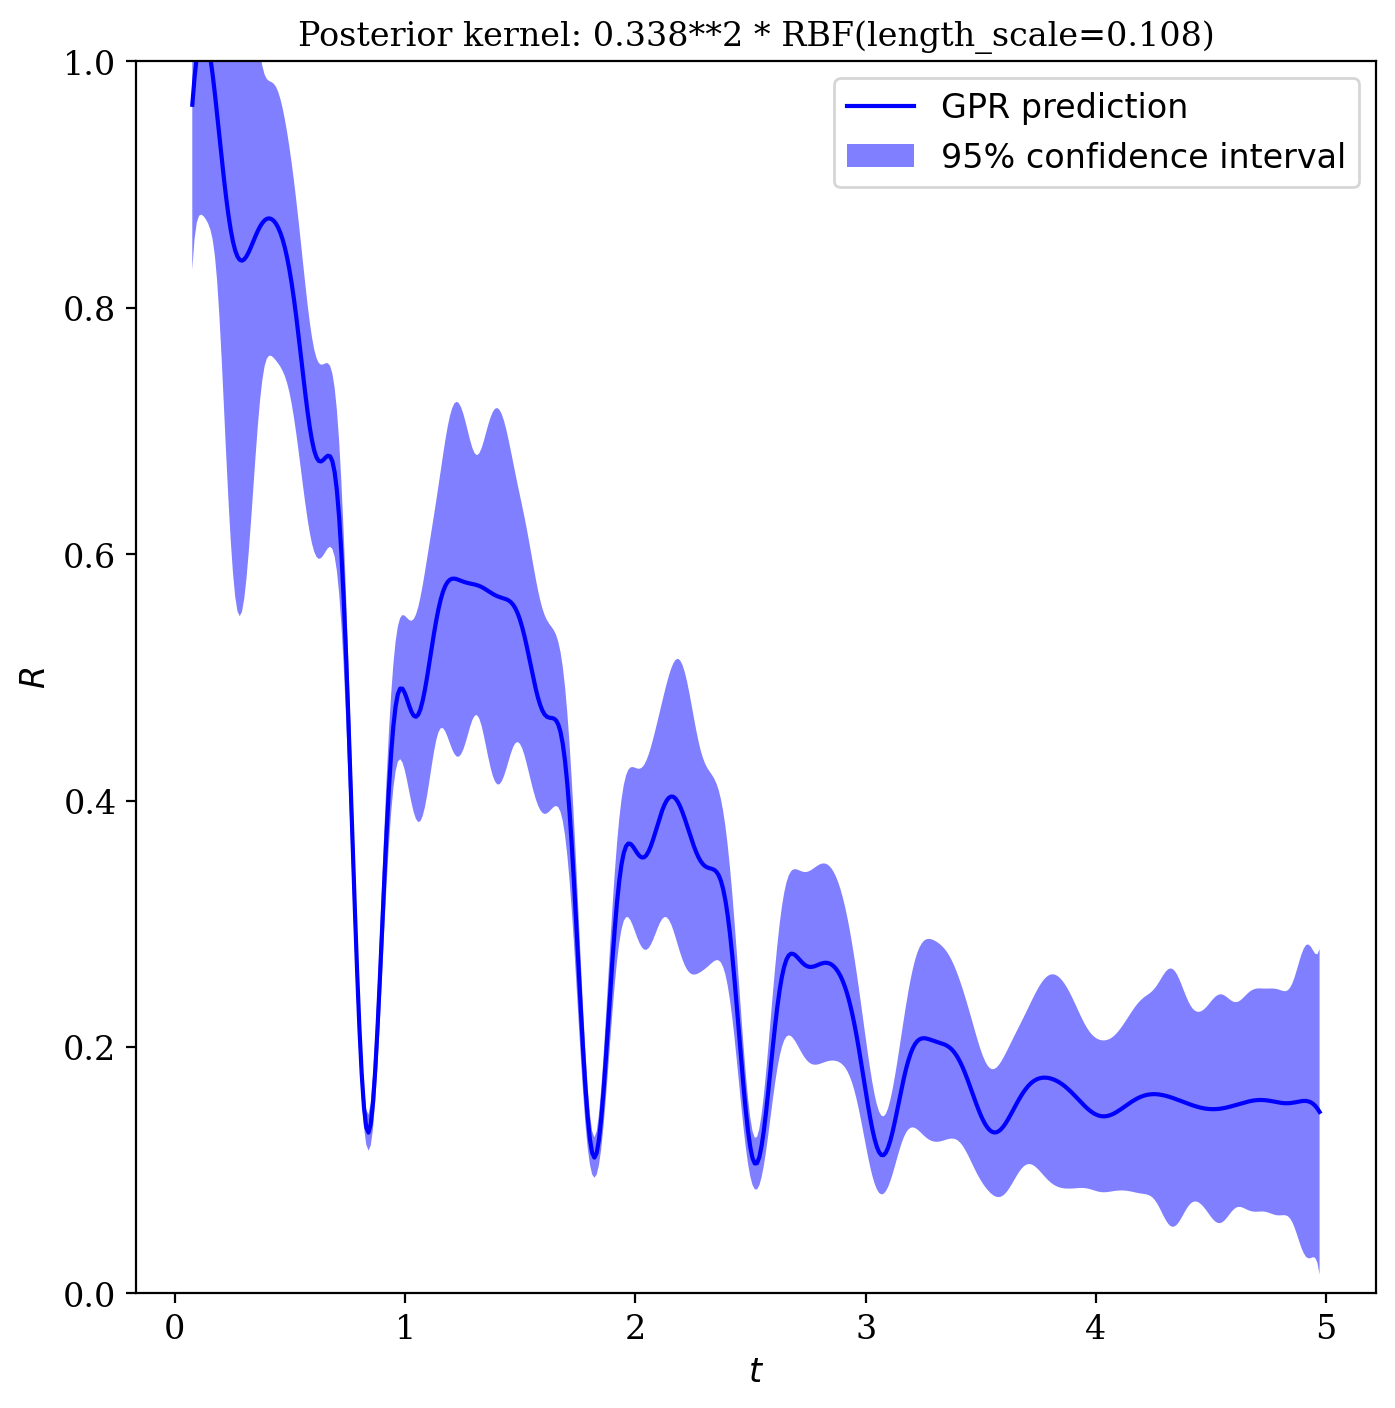

In [14]:
fig1

In [15]:
# Plot the function, the prediction and the 95% confidence interval
fig2, ax2 = plt.subplots()

ax2.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax2.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax2.plot(x_train_sim, y_train_sim, 'ro', markersize=6, label="training points") # Plot train data
ax2.plot(x_test_sim, y_test_sim, 'kX', markersize=6, label="testing points") # Plot test points

ax2.set_xlabel('$t$', font)
ax2.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax2.set_title("Posterior kernel: %s"
              % gp_model_sim.kernel_, font) # Show in the title the value of the hyperparameters
ax2.set_ylim(0, 1) # just to provide more space for the legend
ax2.legend(loc='upper right', fontsize=15)
fig2.set_size_inches(8,8)
plt.savefig("sim_RBF_optimizer_points.png", bbox_inches="tight")
plt.close(fig2) # close the plot to see it in next cell

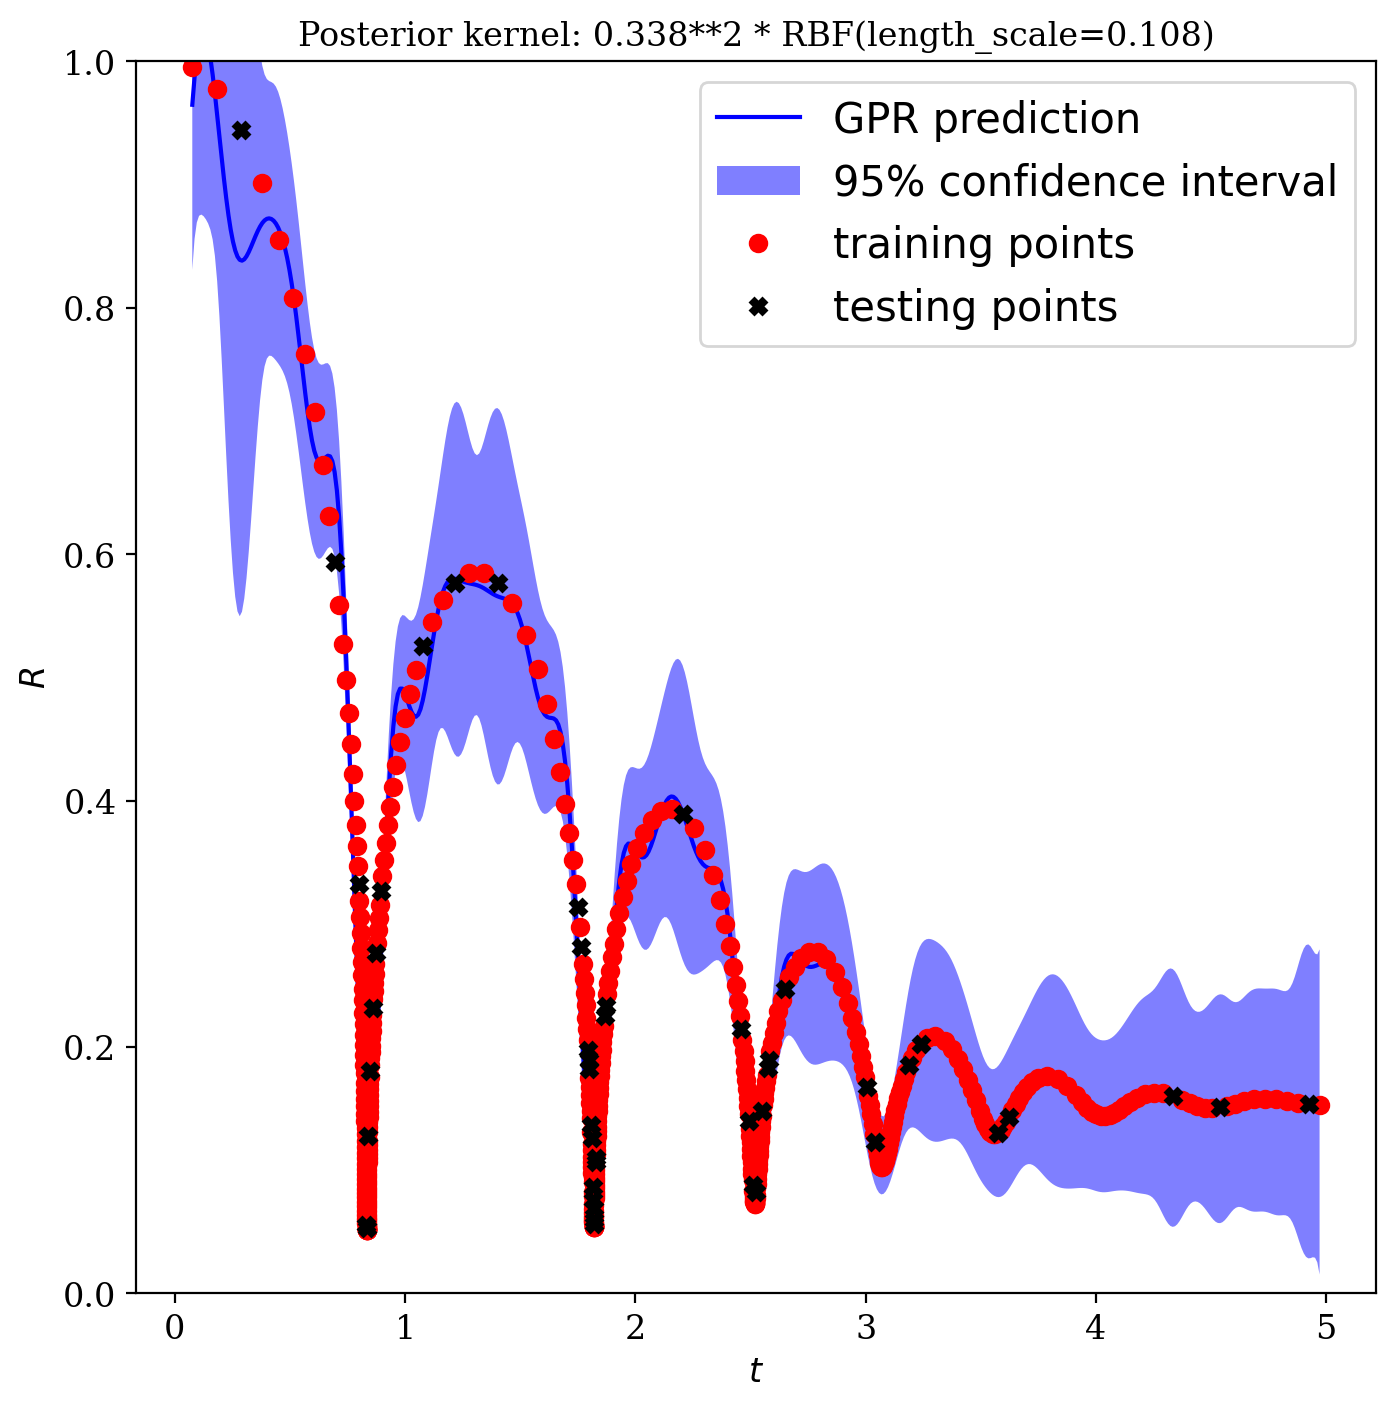

In [16]:
fig2

<c id='Training with Different Kernels: ExpSineSquared with an optimizer fmin_1_bfgs_b'></c>

### Training with Different Kernels: ExpSineSquared with an optimizer fmin_1_bfgs_b

In [17]:
# Quick Kernel Hyperparameter Search
#Define the kernel and identify the hyperparameters 
kernel_ess = ExpSineSquared(length_scale=3.0, periodicity=3.14,
                            length_scale_bounds=(0.1, 10.0),
                            periodicity_bounds=(0.1, 10))

kernel_rbf = RBF(length_scale=3.0, length_scale_bounds=(1e-2, 1e2))

# Combine the kernels
kernel_combined = kernel_ess * kernel_rbf
kernel_combined.get_params().keys()

dict_keys(['k1', 'k2', 'k1__length_scale', 'k1__periodicity', 'k1__length_scale_bounds', 'k1__periodicity_bounds', 'k2__length_scale', 'k2__length_scale_bounds'])

In [18]:
# Step 1: Create a subset of your data
X_subset, _, y_subset, _ = train_test_split(X_data_sim, Y_data_sim, test_size=0.01, random_state=42)

# Step 2: Define hyperparameter grid
param_grid = {
    'kernel__k1__length_scale': [0.1, 1.0],
    'kernel__k1__periodicity': [1.0, 2.0],
    #'kernel__k1__length_scale_bounds': [(1e-2, 1e2)],
    #'kernel__k2__length_scale': [0.1, 1.0, 2.0],
    #'kernel__k2__length_scale_bounds': [(1e-2, 1e2)]
}

# Step 3: Perform grid search on the subset
kernel = ExpSineSquared()
gp_model = GaussianProcessRegressor(kernel=kernel, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=50)
scoring_metrics = {'r2': make_scorer(r2_score), 'neg_mean_squared_error': 'neg_mean_squared_error'}
#grid_search = GridSearchCV(gp_model, param_grid, cv=5, scoring=scoring_metrics, refit='neg_mean_squared_error', n_jobs=-1)
grid_search = GridSearchCV(gp_model, param_grid, cv=2, scoring=scoring_metrics, refit='neg_mean_squared_error')


# Wrap the kernel parameters with double underscores
param_grid = {f'kernel__{key}': value for key, value in param_grid.items()}
grid_search.fit(X_subset, y_subset)

# Step 4: Identify promising hyperparameters!
print("Best Hyperparameters:", grid_search.best_params_)
print("Best R^2 Score on Subset:", grid_search.best_score_)

# Step 5: Refine Hyperparameter Range (manually adjust param_grid)

# Step 6: Could perform a more detailed search on the entire dataset or a larger subset 
# but in the interest of time, will use the hyperparameters with the best error metric performance 

/oscar/home/mcarcana/3dasm_project/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/oscar/home/mcarcana/3dasm_project/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/oscar/home/mcarcana/3dasm_project/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data 

Best Hyperparameters: {'kernel__k1__length_scale': 0.1, 'kernel__k1__periodicity': 1.0}
Best R^2 Score on Subset: -0.035950387170264


In [ ]:
#####TRY THIS INSTEAD OF THE KERNEL HYPERPARAMETER OPTIMIZATION DOING ABOVE
# Step 1: Create a subset of your data
X_subset, _, y_subset, _ = train_test_split(X_data_sim, Y_data_sim, test_size=0.01, random_state=42)

# Step 2: Define hyperparameter grid
param_grid = {
    'kernel__k1__length_scale': [0.1, 1.0],
    'kernel__k1__periodicity': [1.0, 2.0],
}

# Step 3: Perform grid search on the subset
kernel = ExpSineSquared()
gp_model = GaussianProcessRegressor(kernel=kernel, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
scoring_metrics = {'r2': make_scorer(r2_score), 'neg_mean_squared_error': 'neg_mean_squared_error'}

# Initialize an empty list to store results
results = []

# Nested loops for grid search
for length_scale_value in param_grid['kernel__k1__length_scale']:
    for periodicity_value in param_grid['kernel__k1__periodicity']:
        # Update the kernel with the current hyperparameter values
        kernel_params = {'k1__length_scale': length_scale_value, 'k1__periodicity': periodicity_value}
        gp_model.set_params(**kernel_params)

        # Cross-validation with the current hyperparameter values
        grid_search = GridSearchCV(gp_model, param_grid={}, cv=2, scoring=scoring_metrics, refit='neg_mean_squared_error')
        grid_search.fit(X_subset, y_subset)

        # Append results to the list
        results.append({
            'Length Scale': length_scale_value,
            'Periodicity': periodicity_value,
            'Best Hyperparameters': grid_search.best_params_,
            'Best R^2 Score on Subset': grid_search.best_score_,
        })

# Print or use the results list as needed
for result in results:
    print(result)


In [47]:
# GPR
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
kernel_ess = ExpSineSquared(length_scale=3.0, periodicity=3.14,
                        length_scale_bounds=(1, 10.0),
                        periodicity_bounds=(1, 10)) * RBF(3.0, (1e-2, 1e2))
#MSE = 0.0502,R^2 = -0.6916 for alpha = 1e-6 and MSE = 0.0027,R^2 = 0.9076 for alpha = 1e-3

#kernel_ess = ExpSineSquared(length_scale=3.0, periodicity=3.14,
#                       length_scale_bounds=(0.1, 10.0),
#                       periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))
#MSE = 0.0180,R^2 = 0.3924 for alpha = 1e-6

gp_model_sim = GaussianProcessRegressor(kernel=kernel_ess, alpha=1e-3, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
#MSE = 0.0008,R^2 = 0.9719 for 0.1 lower bound and alpha=1e-3

# Fit to data to determine parameters
gp_model_sim.fit(X_train_sim, y_train_sim)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_sim, sigma_plot_sim = gp_model_sim.predict(X_plot_sim, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_sim, sigma_sim = gp_model_sim.predict(X_test_sim, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_ess = mean_squared_error(y_test_sim,y_pred_sim)
r2_ess = r2_score(y_test_sim,y_pred_sim)
print(f"For ExpSineSquared kernel, MSE = {mse_ess:.4f},R^2 = {r2_ess:.4f}")

For ExpSineSquared kernel, MSE = 0.0027,R^2 = 0.9076


/oscar/home/mcarcana/3dasm_project/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified lower bound 1.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/oscar/home/mcarcana/3dasm_project/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__periodicity is close to the specified lower bound 1. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [48]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_sim.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper right', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("sim_ESS_optimizer.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

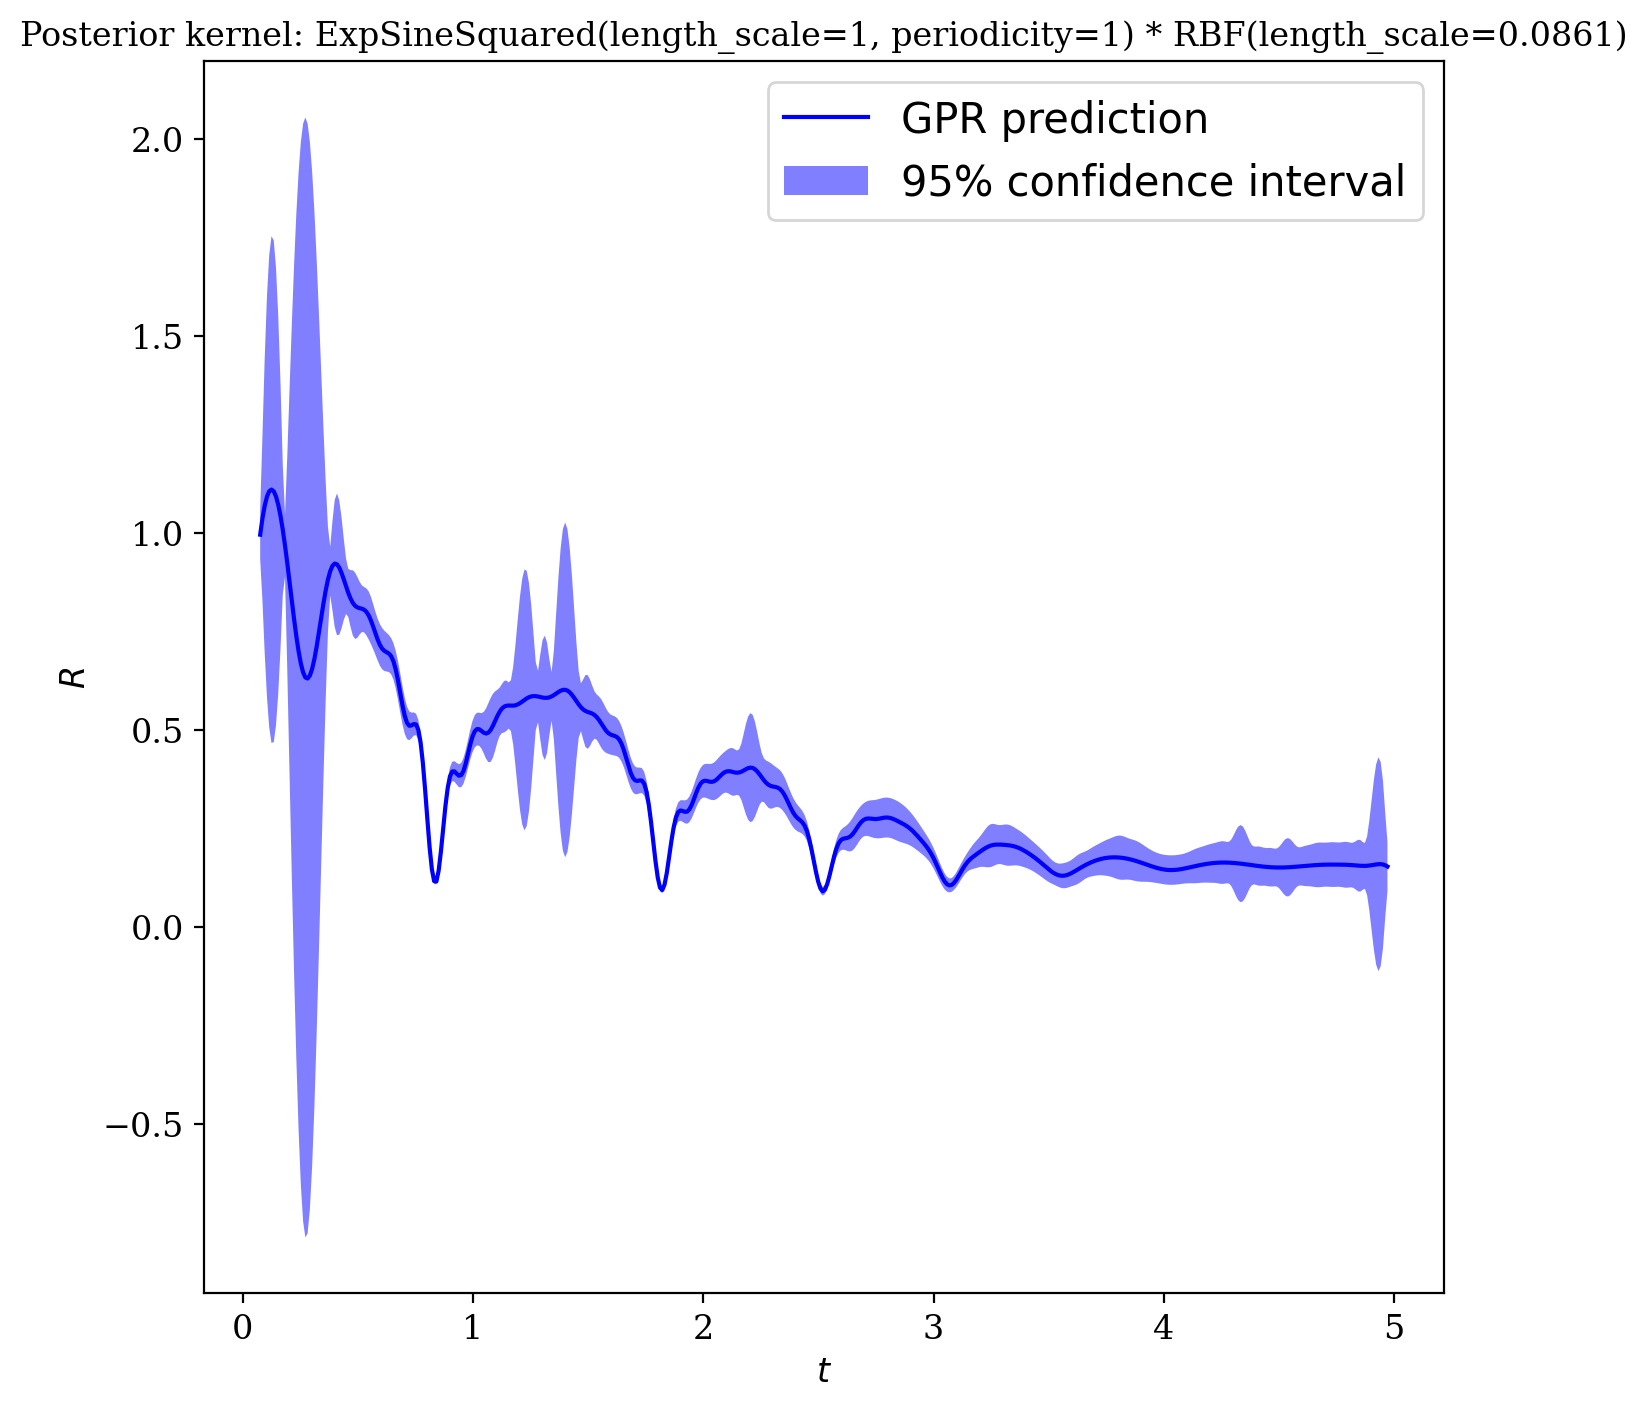

In [49]:
fig1

In [22]:
# Plot the function, the prediction and the 95% confidence interval
fig2, ax2 = plt.subplots()

ax2.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax2.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax2.plot(x_train_sim, y_train_sim, 'ro', markersize=6, label="training points") # Plot train data
ax2.plot(x_test_sim, y_test_sim, 'kX', markersize=6, label="testing points") # Plot test points

ax2.set_xlabel('$t$', font)
ax2.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax2.set_title("Posterior kernel: %s"
              % gp_model_sim.kernel_, font) # Show in the title the value of the hyperparameters
ax2.set_ylim(0, 1) # just to provide more space for the legend
ax2.legend(loc='upper right', fontsize=15)
fig2.set_size_inches(8,8)
plt.savefig("sim_ESS_optimizer_points.png", bbox_inches="tight")
plt.close(fig2) # close the plot to see it in next cell

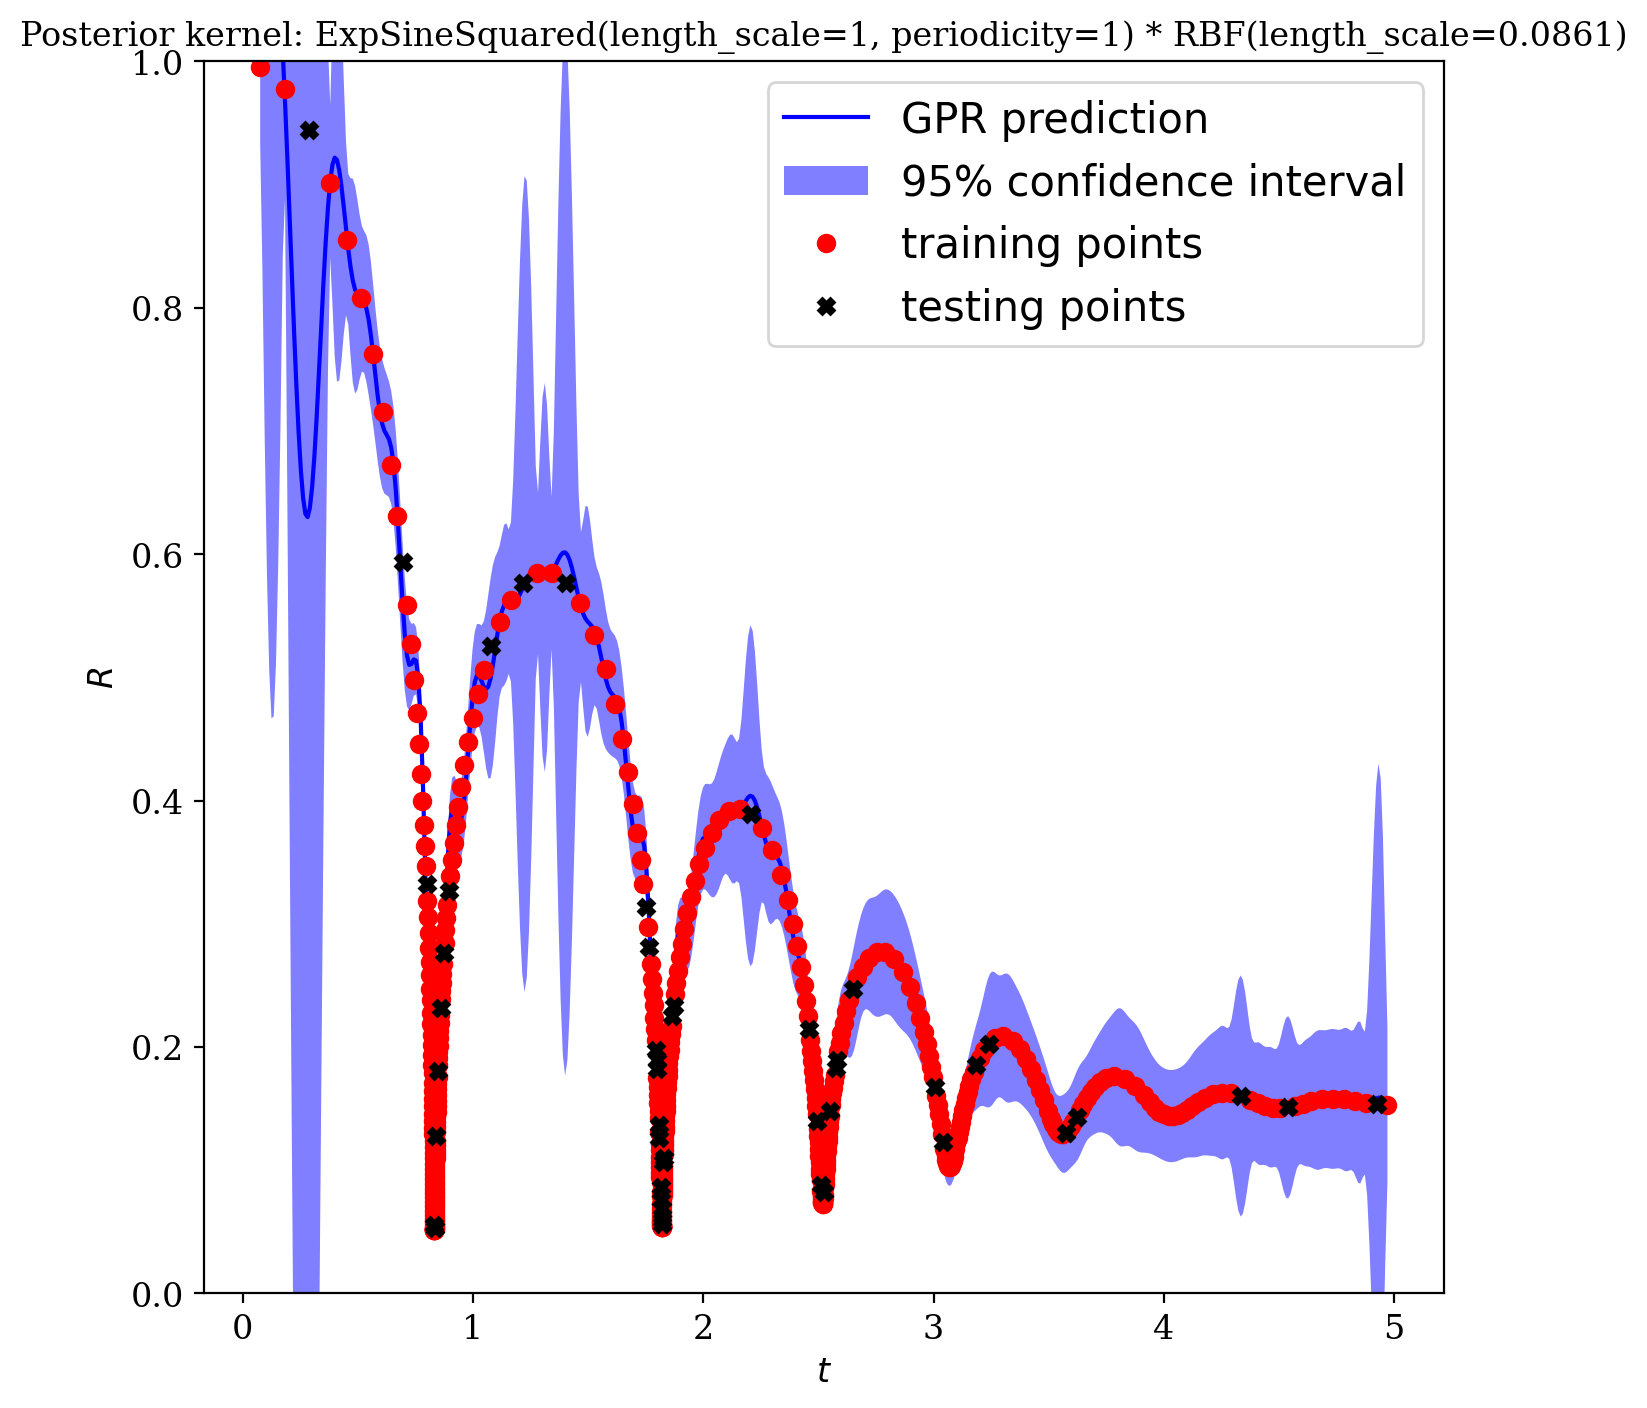

In [23]:
fig2

<d id='Training with Different Kernels: Matern with an optimizer fmin_1_bfgs_b'></d>

### Training with Different Kernels: Matern with an optimizer fmin_1_bfgs_b

In [50]:
# Quick Kernel Hyperparameter Search
#Define the kernel and identify the hyperparameters 
kernel_matern = Matern()
kernel_matern.get_params().keys()

dict_keys(['length_scale', 'length_scale_bounds', 'nu'])

In [ ]:
# Define the range of values for each hyperparameter
length_scale_values = [0.1, 1.0, 2.0]
nu_values = [1.0, 1.5, 2.0]

# Define a scoring function (R^2 and MSE)
scoring_metrics = {'r2': make_scorer(r2_score), 'mean_squared_error': 'mean_squared_error'}

# Create a list to store results
results_list = []

# Hyperparameter search loop
for length_scale_value in length_scale_values:
    for nu_value in nu_values:
        # Define the Matern kernel with the current hyperparameter values
        kernel_matern = Matern(length_scale=length_scale_value, nu=nu_value)

        # Create the Gaussian Process Regressor with the Matern kernel
        gp_model = GaussianProcessRegressor(kernel=kernel_matern, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)

        # Cross-validation with the current hyperparameter values
        scores = cross_validate(gp_model, X_train_sim, y_train_sim, cv=5, scoring=scoring_metrics)

        # Append results to the list
        results_list.append({
            'Length Scale': length_scale_value,
            'Nu': nu_value,
            'R^2 Mean': np.mean(scores['test_r2']),
            'MSE Mean': np.mean(scores['test_mean_squared_error'])  # Use neg_mean_squared_error
        })

# Create a DataFrame from the list
results_df = pd.DataFrame(results_list)

# Print or use the results DataFrame as needed
print(results_df)


In [74]:
# Define the kernel function
kernel_M = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)

gp_model_sim = GaussianProcessRegressor(kernel=kernel_M, alpha=1e-6, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
#gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_sim.fit(X_train_sim, y_train_sim)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_sim, sigma_plot_sim = gp_model_sim.predict(X_plot_sim, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_sim, sigma_sim = gp_model_sim.predict(X_test_sim, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_M = mean_squared_error(y_test_sim,y_pred_sim)
r2_M = r2_score(y_test_sim,y_pred_sim)
print(f"For Matern kernel, MSE = {mse_M:.4f},R^2 = {r2_M:.4f}")

For Matern kernel, MSE = 0.0001,R^2 = 0.9982


In [75]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_sim.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper right', fontsize=15)
ax1.set_ylim(0, 1) # just to provide more space for the legend
fig1.set_size_inches(8,8)
plt.savefig("sim_Matern_optimizer.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

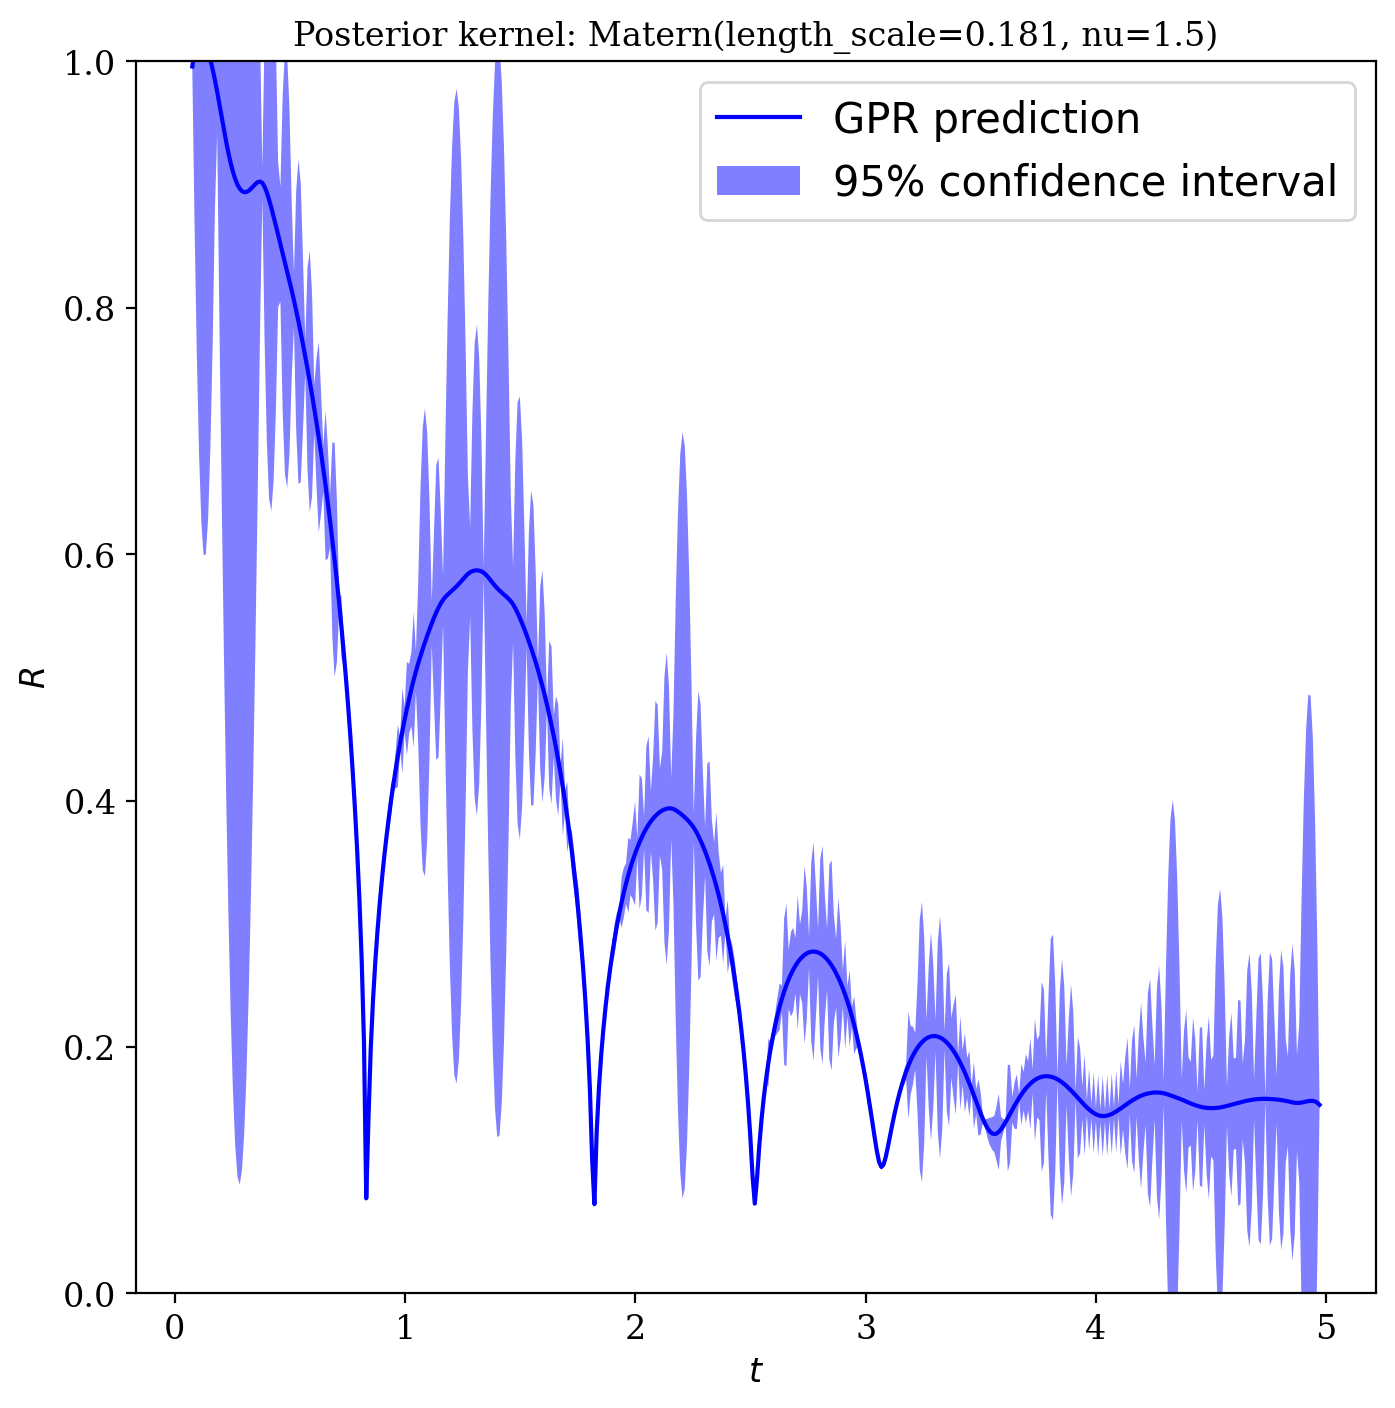

In [76]:
fig1

In [77]:
# Plot the function, the prediction and the 95% confidence interval
fig2, ax2 = plt.subplots()

ax2.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax2.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax2.plot(x_train_sim, y_train_sim, 'ro', markersize=6, label="training points") # Plot train data
ax2.plot(x_test_sim, y_test_sim, 'kX', markersize=6, label="testing points") # Plot test points

ax2.set_xlabel('$t$', font)
ax2.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax2.set_title("Posterior kernel: %s"
              % gp_model_sim.kernel_, font) # Show in the title the value of the hyperparameters
ax2.set_ylim(0, 1) # just to provide more space for the legend
ax2.legend(loc='upper right', fontsize=15)
fig2.set_size_inches(8,8)
plt.savefig("sim_Matern_optimizer_points.png", bbox_inches="tight")
plt.close(fig2) # close the plot to see it in next cell

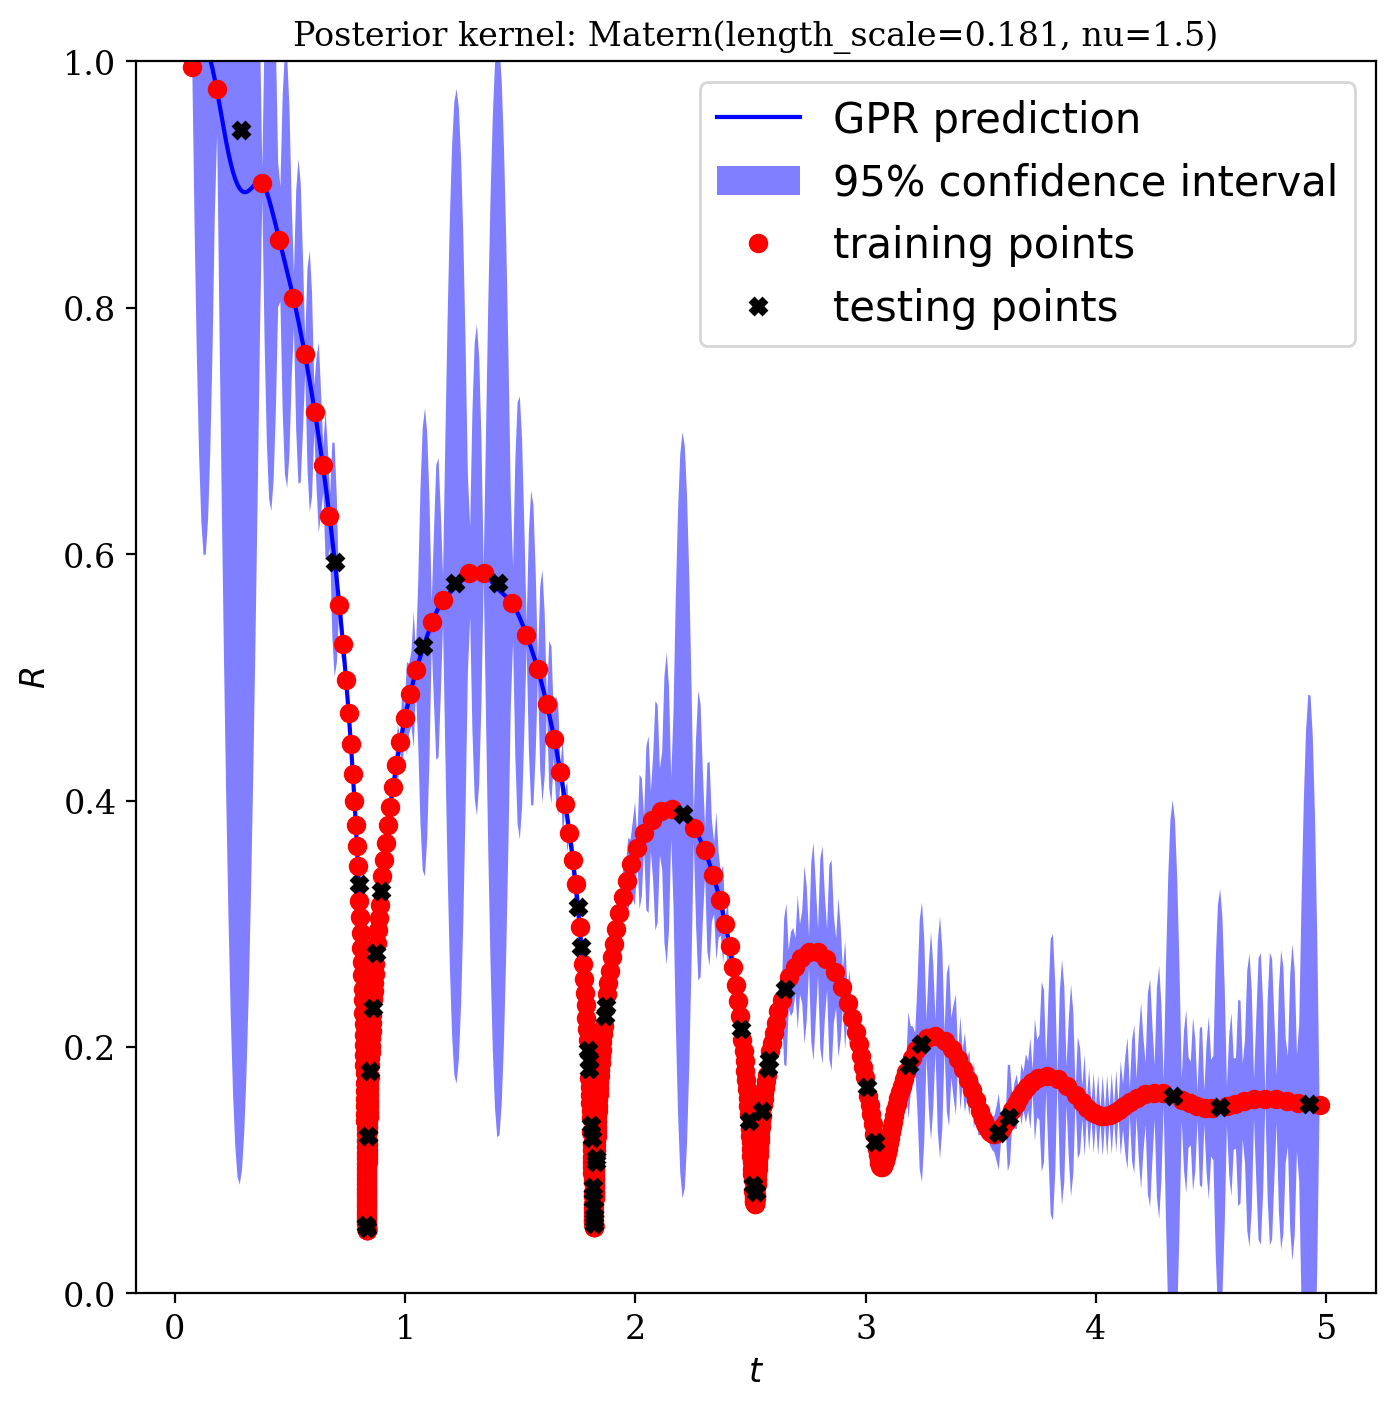

In [78]:
fig2

<e id='Training with Different Kernels: common Constant*RBF kernel With No Optimizer'></e>

### Training with Different Kernels: common Constant*RBF kernel With No Optimizer

In [ ]:
# Define the kernel function
kernel_rbf_noopt = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the very common Constant*RBF kernel

gp_model_rbf_noopt = GaussianProcessRegressor(kernel=kernel_rbf_noopt, alpha=1e-6, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_rbf_noopt.fit(X_train_sim, y_train_sim)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_sim, sigma_plot_sim = gp_model_rbf_noopt.predict(X_plot_sim, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_sim, sigma_sim = gp_model_rbf_noopt.predict(X_test_sim, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_rbf_noopt = mean_squared_error(y_test_sim,y_pred_sim)
r2_rbf_noopt = r2_score(y_test_sim,y_pred_sim)
print(f"For Constant*RBF kernel without an optimizer, MSE = {mse_rbf_noopt:.4f},R^2 = {r2_rbf_noopt:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_rbf_noopt.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper right', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("sim_RBF_no_optimizer_points.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

<f id='Training with Different Kernels: ExpSineSquared with no optimizer'></f>

### Training with Different Kernels: ExpSineSquared with no optimizer

In [ ]:
# Define the kernel function
kernel_ess_noopt = ExpSineSquared(length_scale=3.0, periodicity=3.14,
                        length_scale_bounds=(0.1, 10.0),
                        periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))

gp_model_ess_noopt = GaussianProcessRegressor(kernel=kernel_ess_noopt, alpha=1e-6, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_ess_noopt.fit(X_train_sim, y_train_sim)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_sim, sigma_plot_sim = gp_model_ess_noopt.predict(X_plot_sim, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_sim, sigma_sim = gp_model_ess_noopt.predict(X_test_sim, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_ess_noopt = mean_squared_error(y_test_sim,y_pred_sim)
r2_ess_noopt = r2_score(y_test_sim,y_pred_sim)
print(f"For ExpSineSquared kernel without an optimizer, MSE = {mse_ess_noopt:.4f},R^2 = {r2_ess_noopt:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_ess_noopt.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper right', fontsize=15)
plt.savefig("sim_ESS_no_optimizer.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

<g id='Training with Different Kernels: Matern with no optimizer'></g>

### Training with Different Kernels: Matern with no optimizer

In [ ]:
# Define the kernel function
kernel_m_noopt = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)

gp_model_m_noopt = GaussianProcessRegressor(kernel=kernel_m_noopt, alpha=1e-6, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_m_noopt.fit(X_train_sim, y_train_sim)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_sim, sigma_plot_sim = gp_model_m_noopt.predict(X_plot_sim, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_sim, sigma_sim = gp_model_m_noopt.predict(X_test_sim, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_m_noopt = mean_squared_error(y_test_sim,y_pred_sim)
r2_m_noopt = r2_score(y_test_sim,y_pred_sim)
print(f"For Matern kernel without an optimizer, MSE = {mse_m_noopt:.4f},R^2 = {r2_m_noopt:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_m_noopt.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper right', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("sim_Matern_no_optimizer.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

### different optimizers? different ratios of training/testing data?

<h id='Phase 1.5: Gaussian Process on Experimental Data Only'></h>

# Phase 1.5: Gaussian Process on Experimental Data Only

In [42]:
#import experimental data from collaborators, pre-processing in matlab (including scaling)
exp_df = pd.read_csv("../normalized_unscaled_Experimental_Data_10PA_.06BIS.csv") # read pandas DataFrame
print("Show the experimental DataFrame used for testing data:\n", exp_df)
#Note about data quality: don't need to scale as the data was already normalized 
##so that t is in (0,5) and R is in (0,1) and preprocessed such that data is nondimensionalized

Show the experimental DataFrame used for testing data:
      0.0170220398718178  0.999866408529248
0              0.044679           0.998759
1              0.072336           0.996847
2              0.099993           0.994077
3              0.127651           0.990380
4              0.155308           0.985505
..                  ...                ...
176            4.912334           0.163639
177            4.939991           0.159946
178            4.967648           0.156486
179            4.995306           0.154681
180            5.022963           0.155009

[181 rows x 2 columns]


In [43]:
Data_t_exp = exp_df.iloc[:,0]
Data_R_exp = exp_df.iloc[:,1] 
print("Experimental x data is the time:\n",Data_t_exp)
print("Experimental y data is the bubble radius from the camera:\n",Data_R_exp)

Experimental x data is the time:
 0      0.044679
1      0.072336
2      0.099993
3      0.127651
4      0.155308
         ...   
176    4.912334
177    4.939991
178    4.967648
179    4.995306
180    5.022963
Name: 0.0170220398718178, Length: 181, dtype: float64
Experimental y data is the bubble radius from the camera:
 0      0.998759
1      0.996847
2      0.994077
3      0.990380
4      0.985505
         ...   
176    0.163639
177    0.159946
178    0.156486
179    0.154681
180    0.155009
Name: 0.999866408529248, Length: 181, dtype: float64


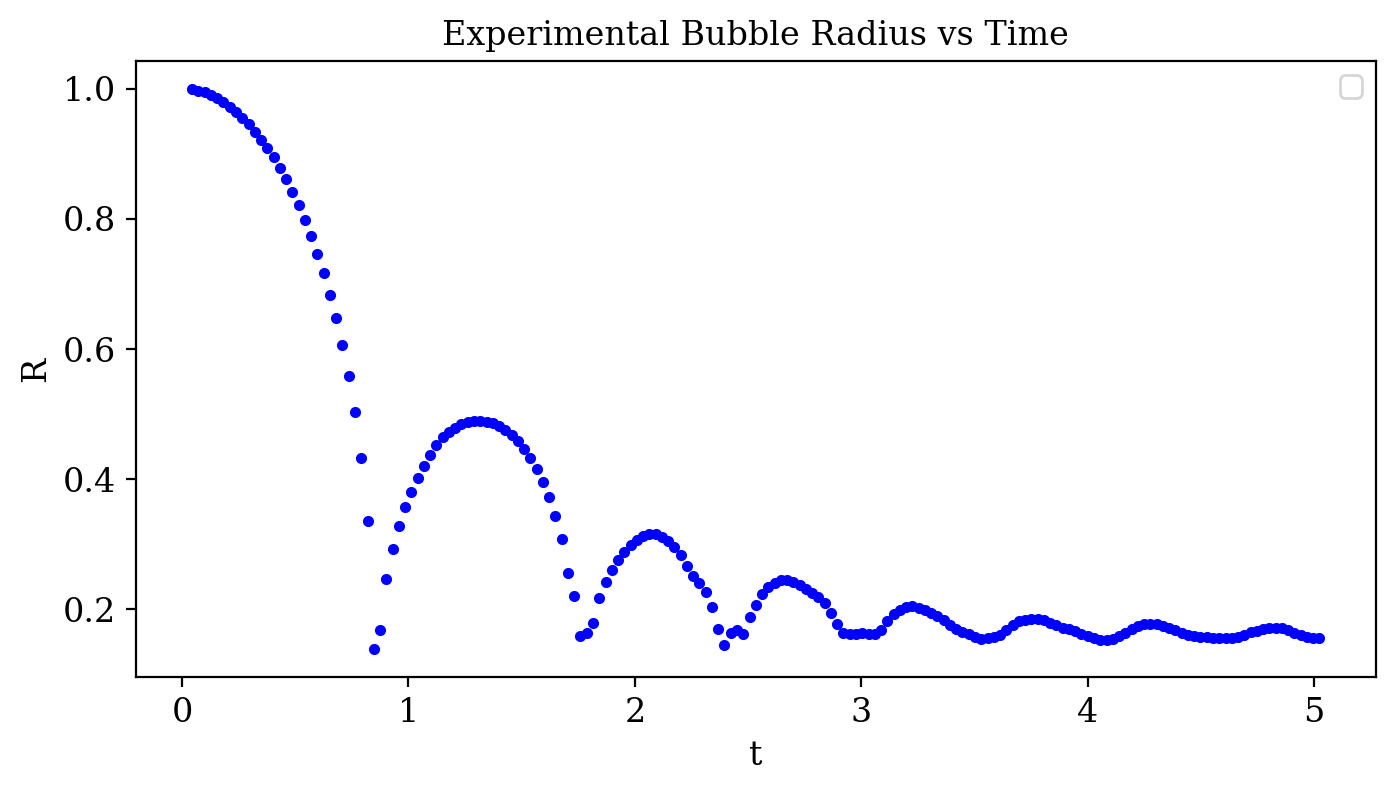

In [44]:
fig_exp_data, ax_exp_data = plt.subplots() # create a plot
ax_exp_data.plot(Data_t_exp, Data_R_exp, 'b.')

ax_exp_data.set_xlabel("t", font) # create x-axis label with font size 20
ax_exp_data.set_ylabel("R", font) # create y-axis label with font size 20
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax_exp_data.set_title("Experimental Bubble Radius vs Time", font); # create title with font size 20

handles, labels = ax_exp_data.get_legend_handles_labels()
ax_exp_data.legend(handles, labels)
plt.savefig("avg_exp_data.png", bbox_inches="tight")
plt.show(fig_exp_data)

In [45]:
n_data = len(Data_t_exp) # number of points in our dataset
testset_ratio = 0.75 # ratio of test set points from the dataset

t_data_exp = np.reshape(Data_t_exp,(-1,1)) # a 2D array that scikit-learn likes

seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

# Let's split into 10% training points and the rest for testing:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(t_data_exp,
                                    Data_R_exp, test_size=testset_ratio,
                                    random_state=seed)

x_train_exp = X_train_exp.ravel() # just for plotting later
x_test_exp = X_test_exp.ravel() # just for plotting later

#print("Here's a print of X_train:\n", X_train_exp)

In [46]:
# Define points used for plotting
n_max_exp = np.max(t_data_exp)
n_min_exp = np.min(t_data_exp)
n_plot_exp = 500 # number of points used for plotting the model
n_max_exp = np.max(t_data_exp)
x_plot_exp = np.linspace(n_min_exp, n_max_exp, n_plot_exp) # create dataset with uniformly spaced points
X_plot_exp = np.reshape(x_plot_exp,(-1,1)) # a 2D array that scikit-learn likes

<i id='Training with Different kernels: common Constant*RBF kernel with an optimizer fmin_1_bfgs_b'></i>

## Training with Different kernels: common Constant*RBF kernel with an optimizer fmin_1_bfgs_b

In [ ]:
# Define the kernel function
kernel_rbf = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the very common Constant*RBF kernel

gp_model_exp_rbf = GaussianProcessRegressor(kernel=kernel_rbf, alpha=1e-2, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
#gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_exp_rbf.fit(X_train_exp, y_train_exp)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_exp, sigma_plot_exp = gp_model_exp_rbf.predict(X_plot_exp, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_exp, sigma_exp = gp_model_exp_rbf.predict(X_test_exp, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_exp_rbf = mean_squared_error(y_test_exp,y_pred_exp)
r2_exp_rbf = r2_score(y_test_exp,y_pred_exp)
print(f"For Constant*RBF kernel for experimental data, MSE = {mse_exp_rbf:.4f},R^2 = {r2_exp_rbf:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_exp, y_plot_pred_exp, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_exp, x_plot_exp[::-1]]),
         np.concatenate([y_plot_pred_exp - 1.9600 * sigma_plot_exp,
                        (y_plot_pred_exp + 1.9600 * sigma_plot_exp)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.plot(x_train_exp, y_train_exp, 'ro', markersize=6, label="training points") # Plot train data
ax1.plot(x_test_exp, y_test_exp, 'kX', markersize=6, label="testing points") # Plot test points

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_exp_rbf.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper right', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("exp_RBF_optimizer_points.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

<j id='Training with Different Kernels: ExpSineSquared with an optimizer fmin_1_bfgs_b'></j>

### Training with Different Kernels: ExpSineSquared with an optimizer fmin_1_bfgs_b

In [ ]:
# Define the kernel function
kernel_ess = ExpSineSquared(length_scale=3.0, periodicity=3.14,
                        length_scale_bounds=(0.1, 10.0),
                        periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))

gp_model_exp_ess = GaussianProcessRegressor(kernel=kernel_ess, alpha=1e-2, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
#gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_exp_ess.fit(X_train_exp, y_train_exp)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_exp, sigma_plot_exp = gp_model_exp_ess.predict(X_plot_exp, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_exp, sigma_exp = gp_model_exp_ess.predict(X_test_exp, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_exp_ess = mean_squared_error(y_test_exp,y_pred_exp)
r2_exp_ess = r2_score(y_test_exp,y_pred_exp)
print(f"For ExpSineSquared kernel for experimental data, MSE = {mse_exp_ess:.4f},R^2 = {r2_exp_ess:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_exp, y_plot_pred_exp, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_exp, x_plot_exp[::-1]]),
         np.concatenate([y_plot_pred_exp - 1.9600 * sigma_plot_exp,
                        (y_plot_pred_exp + 1.9600 * sigma_plot_exp)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.plot(x_train_exp, y_train_exp, 'ro', markersize=6, label="training points") # Plot train data
ax1.plot(x_test_exp, y_test_exp, 'kX', markersize=6, label="testing points") # Plot test points

ax1.set_xlabel('$t$', fontsize=20)
ax1.set_ylabel('$R$', fontsize=20)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_exp_ess.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper right', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("exp_ESS_optimizer_points.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

<k id='Training with Different Kernels: Matern with an optimizer fmin_1_bfgs_b'></k>

### Training with Different Kernels: Matern with an optimizer fmin_1_bfgs_b

In [ ]:
# Define the kernel function
kernel_m = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)

gp_model_exp_m = GaussianProcessRegressor(kernel=kernel_m, alpha=1e-2, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
#gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_exp_m.fit(X_train_exp, y_train_exp)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_exp, sigma_plot_exp = gp_model_exp_m.predict(X_plot_exp, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_exp, sigma_exp = gp_model_exp_m.predict(X_test_exp, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_exp_m = mean_squared_error(y_test_exp,y_pred_exp)
r2_exp_m = r2_score(y_test_exp,y_pred_exp)
print(f"For Matern kernel for experimental data, MSE = {mse_exp_m:.4f},R^2 = {r2_exp_m:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_exp, y_plot_pred_exp, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_exp, x_plot_exp[::-1]]),
         np.concatenate([y_plot_pred_exp - 1.9600 * sigma_plot_exp,
                        (y_plot_pred_exp + 1.9600 * sigma_plot_exp)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.plot(x_train_exp, y_train_exp, 'ro', markersize=6, label="training points") # Plot train data
ax1.plot(x_test_exp, y_test_exp, 'kX', markersize=6, label="testing points") # Plot test points

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_exp_m.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper right', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("exp_Matern_optimizer_points.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

<l id='Phase 2: Training with Simulation Data and Testing with Experimental Data'></l>

# Phase 2: Training with Simulation Data and Testing with Experimental Data
## running with Constant Kernel and  f_min optimizer, Matern kernel with no optimizer

In [ ]:
# training data = simulation data, test data = experimental data

# defining training data
X_train_LF = X_data_sim # a 2D array that scikit-learn likes, for simulated data
y_train_LF = Data_y_sim

# defining test data
X_test_HF = t_data_exp
y_test_HF = Data_R_exp

n_data = len(Data_t_exp) # number of points in our dataset

x_train_LF = X_train_LF.ravel() # just for plotting later
x_test_HF = X_test_HF.ravel() # just for plotting later

print(len(X_train_LF))
print(len(y_train_LF))

print(len(X_test_HF))
print(len(y_test_HF))

# Define points used for plotting
n_max_MF = np.max(X_train_LF)
n_min_MF = np.min(X_train_LF)
n_plot = 500 # number of points used for plotting the model
x_plot_MF = np.linspace(n_min_MF, n_max_MF, n_plot) # create dataset with uniformly spaced points
X_plot_MF = np.reshape(x_plot_MF,(-1,1)) # a 2D array that scikit-learn likes

<m id='Constant Kernel and  f_min optimizer'></m>

### Constant Kernel and  f_min optimizer

In [ ]:
# Define the kernel function
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the very common Constant*RBF kernel

gp_model_MF_rbf = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_MF_rbf.fit(X_train_LF, y_train_LF)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_MF, sigma_plot_MF = gp_model_MF_rbf.predict(X_plot_MF, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_MF, sigma_MF = gp_model_MF_rbf.predict(X_test_HF, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_MF_rbf = mean_squared_error(y_test_HF,y_pred_MF)
r2_MF_rbf = r2_score(y_test_HF,y_pred_MF)
print(f"For Constant*RBF kernel for multi-fidelity data, MSE = {mse_MF_rbf:.4f},R^2 = {r2_MF_rbf:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_MF, y_plot_pred_MF, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_MF, x_plot_MF[::-1]]),
         np.concatenate([y_plot_pred_MF - 1.9600 * sigma_plot_MF,
                        (y_plot_pred_MF + 1.9600 * sigma_plot_MF)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_MF_rbf.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper right', fontsize=15)
ax1.set_ylim(0,1)
fig1.set_size_inches(8,8)
plt.savefig("simexp_RBF_optimizer.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_MF, y_plot_pred_MF, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_MF, x_plot_MF[::-1]]),
         np.concatenate([y_plot_pred_MF - 1.9600 * sigma_plot_MF,
                        (y_plot_pred_MF + 1.9600 * sigma_plot_MF)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.plot(x_train_LF, y_train_LF, 'ro', markersize=6, label="training points") # Plot train data
ax1.plot(x_test_HF, y_test_HF, 'kX', markersize=6, label="testing points") # Plot test points

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_MF_rbf.kernel_, font) # Show in the title the value of the hyperparameters
ax1.set_ylim(0,1)
ax1.legend(loc='upper right', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("simexp_RBF_optimizer_points.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

<n id='Matern kernel with no optimizer'></n>

### Matern kernel with no optimizer

In [ ]:
# Define the kernel function
kernel_m = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)

gp_model_mf_m = GaussianProcessRegressor(kernel=kernel_m, alpha=1e-6, optimizer=None, n_restarts_optimizer=20)
#with the 'fmin_l_bfgs_b' optimizer, MSE = 0.0788,R^2 = -0.3271 and with no optimizer: MSE = 0.0788,R^2 = -0.3271

# Fit to data to determine parameters
gp_model_mf_m.fit(X_train_LF, y_train_LF)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_mf_m, sigma_plot_mf_m = gp_model_mf_m.predict(X_plot_MF, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_mf_m, sigma_mf_m = gp_model_mf_m.predict(X_test_HF, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_MF_m = mean_squared_error(y_test_HF,y_pred_MF)
r2_MF_m = r2_score(y_test_HF,y_pred_MF)
print(f"For Matern kernel for multi-fidelity data, MSE = {mse_MF_m:.4f},R^2 = {r2_MF_m:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_MF, y_plot_pred_mf_m, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_MF, x_plot_MF[::-1]]),
         np.concatenate([y_plot_pred_mf_m - 1.9600 * sigma_plot_mf_m,
                        (y_plot_pred_mf_m + 1.9600 * sigma_plot_mf_m)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_mf_m.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper right', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("simexp_Matern_optimizer.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

In [ ]:
# Plot the prediction and the 95% confidence interval
fig2, ax2 = plt.subplots()

ax2.plot(x_plot_MF, y_plot_pred_MF, 'b-', label="GPR prediction")
ax2.fill(np.concatenate([x_plot_MF, x_plot_MF[::-1]]),
         np.concatenate([y_plot_pred_MF - 1.9600 * sigma_plot_MF,
                        (y_plot_pred_MF + 1.9600 * sigma_plot_MF)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax2.plot(x_train_LF, y_train_LF, 'ro', markersize=6, label="training points") # Plot train data
ax2.plot(x_test_HF, y_test_HF, 'kX', markersize=6, label="testing points") # Plot test points

ax2.set_xlabel('$t (s)$', font)
ax2.set_ylabel('$r (m)$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax2.set_title("Posterior kernel: %s"
              % gp_model_mf_m.kernel_, font) # Show in the title the value of the hyperparameters
ax2.set_ylim(0,1)
ax2.legend(loc='upper right', fontsize=15)
fig2.set_size_inches(8,8)
plt.savefig("simexp_Matern_optimizer_points.png", bbox_inches="tight")
plt.close(fig2) # close the plot to see it in next cell

In [ ]:
fig2

<o id='Phase 3: Multi-fidelity Gaussian Process'></o>

# Phase 3: Multi-fidelity Gaussian Process
## GPyTorch Regression for Experimental and Simulated Bubble Dynamics
## Multi-fidelity - Scikit-learn

In [ ]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload

In [ ]:
# Setting up Training and Testing Data
train_x_LF = torch.Tensor(x_train_LF)
train_y_LF = torch.Tensor(y_train_LF)

X_test_HF = torch.Tensor(X_test_HF)
y_test_HF = torch.Tensor(y_test_HF)

# Stack the time tensor vertically to create a 2D tensor (column vector)
# The resulting tensor will have shape (num_points, 1)
input_tensor_LF = train_x_LF.view(-1, 1)

In [ ]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x_LF, train_y_LF, likelihood):
        super(ExactGPModel, self).__init__(train_x_LF, train_y_LF, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
#likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood = gpytorch.likelihoods.GaussianLikelihood(jitter=1e-4)
model = ExactGPModel(train_x_LF, train_y_LF, likelihood)

In [ ]:
# Setting up Training and Testing Data
train_x_LF = torch.Tensor(x_train_LF)
train_y_LF = torch.Tensor(y_train_LF)

X_test_HF = torch.Tensor(X_test_HF)
y_test_HF = torch.Tensor(y_test_HF)

# Stack the time tensor vertically to create a 2D tensor (column vector)
# The resulting tensor will have shape (num_points, 1)
#input_tensor_LF = train_x_LF.view(-1, 1)



# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x_LF, train_y_LF, likelihood):
        super(ExactGPModel, self).__init__(train_x_LF, train_y_LF, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood = gpytorch.likelihoods.GaussianLikelihood(jitter=1e-4)
model = ExactGPModel(train_x_LF, train_y_LF, likelihood)



# this is for running the notebook in our testing framework
import torch.optim as optim
import os
smoke_test = ('CI' in os.environ)
training_iter = 10 if smoke_test else 25

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# Initialize the LBFGS optimizer
#optimizer = optim.LBFGS(model.parameters(), lr=0.1)
#optimizer = optim.LBFGS(model.parameters(), lr=0.5)  # Experiment with different values
#optimizer = optim.LBFGS(model.parameters(), lr=0.1, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=100, line_search_fn='strong_wolfe')
optimizer = optim.LBFGS(model.parameters(), lr=0.01, max_iter=20, max_eval=None, tolerance_grad=1e-09, tolerance_change=1e-09, history_size=100, line_search_fn='strong_wolfe')

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Define the closure function for LBFGS optimization
def closure():
    optimizer.zero_grad()
    output = model(train_x_LF)
    loss = -mll(output, train_y_LF)
    loss.backward()
    return loss

# Add jitter to the Cholesky decomposition
#with gpytorch.settings.max_cholesky_size(0):  # Disable automatic jitter
   # try:
    # optimizer.step(closure)
   # except gpytorch.errors.NotPSDError:
    #    print("Caught NotPSDError, adding jitter to the Cholesky decomposition.")
     #   model.covar_module.base_kernel.raw_lengthscale.data.add_(torch.tensor(1e-5))

# Run LBFGS optimization
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # Output from model
    output = model(train_x_LF)
    
    # Calculate loss and backprop gradients
    loss = -mll(output, train_y_LF)
    loss.backward()
    
    # Calculate and print the gradient norm
    grad_norm = torch.norm(torch.cat([p.grad.flatten() for p in model.parameters()]))
    
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f   Gradient Norm: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item(),
        grad_norm.item()
    ))
    
    # Take an optimization step
    optimizer.step(closure)

#found decreasing the learning rate to 0.1 leads to lengthscale of 0.018 while learning rate =0.01 leads to lengthscale: 0.022

In [ ]:
# Setting up Training and Testing Data
train_x_LF = torch.Tensor(x_train_LF)
train_y_LF = torch.Tensor(y_train_LF)

x_test_HF = torch.Tensor(X_test_HF)
y_test_HF = torch.Tensor(y_test_HF)

# Stack the time tensor vertically to create a 2D tensor (column vector)
# The resulting tensor will have shape (num_points, 1)
#input_tensor_LF = train_x_LF.view(-1, 1)



# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x_LF, train_y_LF, likelihood):
        super(ExactGPModel, self).__init__(train_x_LF, train_y_LF, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood = gpytorch.likelihoods.GaussianLikelihood(jitter=1e-4)
model = ExactGPModel(train_x_LF, train_y_LF, likelihood)



# this is for running the notebook in our testing framework
import torch.optim as optim
import os
smoke_test = ('CI' in os.environ)
training_iter = 10 if smoke_test else 125

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # Output from model
    output = model(train_x_LF)
    
    # Calculate loss and backprop gradients
    loss = -mll(output, train_y_LF)
    loss.backward()
    
    # Calculate and print the gradient norm
    grad_norm = torch.norm(torch.cat([p.grad.flatten() for p in model.parameters()]))
    
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f   Gradient Norm: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item(),
        grad_norm.item()
    ))
    
    # Take an optimization step
    optimizer.step()

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-1, 1, 51)
    observed_pred = likelihood(model(x_test_HF))

# Extract the mean and covariance of the predictions
mean_pred = observed_pred.mean.numpy()
covar_pred = observed_pred.covariance_matrix.numpy()

# Assuming you have ground truth test_y_LF as well
ground_truth = y_test_HF.numpy()

# Compute R^2 and MSE
r2 = r2_score(ground_truth, mean_pred)
mse = mean_squared_error(ground_truth, mean_pred)

# Save the metrics or use them as needed
#with open("metrics.txt", "w") as f:
#    f.write(f"R^2: {r2}\nMSE: {mse}")

# Print the metrics
print(f"R^2: {r2}")
print(f"MSE: {mse}")

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()

    # Flatten tensors and convert to NumPy arrays
    train_x_LF_np = train_x_LF.numpy().flatten()
    train_y_LF_np = train_y_LF.numpy().flatten()
    x_test_HF_np = x_test_HF.numpy().flatten()
    observed_mean_np = observed_pred.mean.numpy().flatten()
    
    # Plot training data as black stars
    ax.plot(train_x_LF_np, train_y_LF_np, 'k*')
    # Plot predictive means as blue line
    ax.plot(x_test_HF_np, observed_mean_np, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test_HF_np, lower.numpy().flatten(), upper.numpy().flatten(), alpha=0.5)
    ax.set_ylim([0, 1.0])
    ax.legend(['Observed Data', 'Prediction', 'Confidence'])

    plt.xticks(fontname = "serif", fontsize=12)
    plt.yticks(fontname = "serif", fontsize=12)
    #ax.set_title("Multivariate Normal Gaussian with Posterior kernel: %s"
    #          % likelihood_, font) # Show in the title the value of the hyperparameters
   
    #ax.set_title("Multivariate Normal Gaussian with Posterior kernel: %s"
    #          % (likelihood_, kernel_type), font)
    #ax.set_title("Multivariate Normal Gaussian with Posterior kernel: %s"
    #          % (likelihood_, kernel_type), font)
    #ax.set_title("Multivariate Normal Gaussian with Posterior kernel: %s" % kernel_type, font)

    # Assuming your model has a `covar_module` attribute
    #kernel_type = type(model.covar_module).__name__
    mean_type = type(model.mean_module).__name__
    kernel_type = type(model.covar_module.base_kernel).__name__
    #ax.set_title("Multivariate Normal Gaussian with Posterior Mean: %s, Kernel: %s" % (mean_type, kernel_type), font)
    ax.set_title("Multivariate Normal Gaussian with Posterior kernel: %s" % kernel_type, font)

    plt.savefig("multifidelity_singletask_gpy.png", bbox_inches="tight")

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()

    # Flatten tensors and convert to NumPy arrays
    train_x_LF_np = train_x_LF.numpy().flatten()
    train_y_LF_np = train_y_LF.numpy().flatten()
    x_test_HF_np = x_test_HF.numpy().flatten()
    observed_mean_np = observed_pred.mean.numpy().flatten()
    
    # Plot training data as black stars
    #ax.plot(train_x_LF_np, train_y_LF_np, 'k*')
    # Plot predictive means as blue line
    ax.plot(x_test_HF_np, observed_mean_np, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test_HF_np, lower.numpy().flatten(), upper.numpy().flatten(), alpha=0.5)
    ax.set_ylim([0, 1.0])
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.legend(['Prediction', 'Confidence'])

    plt.xticks(fontname = "serif", fontsize=12)
    plt.yticks(fontname = "serif", fontsize=12)

    # Assuming your model has a `covar_module` attribute
    #kernel_type = type(model.covar_module).__name__
    mean_type = type(model.mean_module).__name__
    kernel_type = type(model.covar_module.base_kernel).__name__
    #ax.set_title("Multivariate Normal Gaussian with Posterior Mean: %s, Kernel: %s" % (mean_type, kernel_type), font)
    ax.set_title("Multivariate Normal Gaussian with Posterior kernel: %s" % kernel_type, font)

    plt.savefig("multifidelity_singletask_gpy_nopoints.png", bbox_inches="tight")

### GPyTorch: Multifidelity - Matern kernel

In [ ]:
import gpytorch

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x_LF, train_y_LF, likelihood):
        super(ExactGPModel, self).__init__(train_x_LF, train_y_LF, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        # Use Matern kernel instead of RBF
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5)  # You can adjust the value of nu as needed
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
# Setting up Training and Testing Data
train_x_LF = torch.Tensor(x_train_LF)
train_y_LF = torch.Tensor(y_train_LF)

x_test_HF = torch.Tensor(X_test_HF)
y_test_HF = torch.Tensor(y_test_HF)

# Stack the time tensor vertically to create a 2D tensor (column vector)
# The resulting tensor will have shape (num_points, 1)
#input_tensor_LF = train_x_LF.view(-1, 1)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood = gpytorch.likelihoods.GaussianLikelihood(jitter=1e-4)
model = ExactGPModel(train_x_LF, train_y_LF, likelihood)



# this is for running the notebook in our testing framework
import torch.optim as optim
import os
smoke_test = ('CI' in os.environ)
training_iter = 10 if smoke_test else 125

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # Output from model
    output = model(train_x_LF)
    
    # Calculate loss and backprop gradients
    loss = -mll(output, train_y_LF)
    loss.backward()
    
    # Calculate and print the gradient norm
    grad_norm = torch.norm(torch.cat([p.grad.flatten() for p in model.parameters()]))
    
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f   Gradient Norm: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item(),
        grad_norm.item()
    ))
    
    # Take an optimization step
    optimizer.step()

In [ ]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-1, 1, 51)
    observed_pred = likelihood(model(x_test_HF))

# Extract the mean and covariance of the predictions
mean_pred = observed_pred.mean.numpy()
covar_pred = observed_pred.covariance_matrix.numpy()

# Assuming you have ground truth test_y_LF as well
ground_truth = y_test_HF.numpy()

# Compute R^2 and MSE
r2 = r2_score(ground_truth, mean_pred)
mse = mean_squared_error(ground_truth, mean_pred)

# Print the metrics
print(f"R^2: {r2}")
print(f"MSE: {mse}")

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()

    # Flatten tensors and convert to NumPy arrays
    train_x_LF_np = train_x_LF.numpy().flatten()
    train_y_LF_np = train_y_LF.numpy().flatten()
    x_test_HF_np = x_test_HF.numpy().flatten()
    observed_mean_np = observed_pred.mean.numpy().flatten()
    
    # Plot training data as black stars
    ax.plot(train_x_LF_np, train_y_LF_np, 'k*')
    # Plot predictive means as blue line
    ax.plot(x_test_HF_np, observed_mean_np, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test_HF_np, lower.numpy().flatten(), upper.numpy().flatten(), alpha=0.5)
    ax.set_ylim([0, 1.0])
    ax.legend(['Observed Data', 'Prediction', 'Confidence'])

    plt.xticks(fontname = "serif", fontsize=12)
    plt.yticks(fontname = "serif", fontsize=12)
    #ax.set_title("Multivariate Normal Gaussian with Posterior kernel: %s"
    #          % likelihood_, font) # Show in the title the value of the hyperparameters
   
    #ax.set_title("Multivariate Normal Gaussian with Posterior kernel: %s"
    #          % (likelihood_, kernel_type), font)
    #ax.set_title("Multivariate Normal Gaussian with Posterior kernel: %s"
    #          % (likelihood_, kernel_type), font)
    #ax.set_title("Multivariate Normal Gaussian with Posterior kernel: %s" % kernel_type, font)

    # Assuming your model has a `covar_module` attribute
    #kernel_type = type(model.covar_module).__name__
    mean_type = type(model.mean_module).__name__
    kernel_type = type(model.covar_module.base_kernel).__name__
    #ax.set_title("Multivariate Normal Gaussian with Posterior Mean: %s, Kernel: %s" % (mean_type, kernel_type), font)
    ax.set_title("Multivariate Normal Gaussian with Posterior kernel: %s" % kernel_type, font)

    plt.savefig("multifidelity_singletask_gpy_m.png", bbox_inches="tight")

In [ ]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()

    # Flatten tensors and convert to NumPy arrays
    train_x_LF_np = train_x_LF.numpy().flatten()
    train_y_LF_np = train_y_LF.numpy().flatten()
    x_test_HF_np = x_test_HF.numpy().flatten()
    observed_mean_np = observed_pred.mean.numpy().flatten()
    
    # Plot training data as black stars
    #ax.plot(train_x_LF_np, train_y_LF_np, 'k*')
    # Plot predictive means as blue line
    ax.plot(x_test_HF_np, observed_mean_np, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test_HF_np, lower.numpy().flatten(), upper.numpy().flatten(), alpha=0.5)
    ax.set_ylim([0, 1.0])
    ax.legend(['Prediction','Confidence'])

    plt.xticks(fontname = "serif", fontsize=12)
    plt.yticks(fontname = "serif", fontsize=12)

    # Assuming your model has a `covar_module` attribute
    #kernel_type = type(model.covar_module).__name__
    mean_type = type(model.mean_module).__name__
    kernel_type = type(model.covar_module.base_kernel).__name__
    #ax.set_title("Multivariate Normal Gaussian with Posterior Mean: %s, Kernel: %s" % (mean_type, kernel_type), font)
    ax.set_title("Multivariate Normal Gaussian with Posterior kernel: %s" % kernel_type, font)

    plt.savefig("multifidelity_singletask_gpy_m_nopoints.png", bbox_inches="tight")

# Phase 4: Multitask GP Regression

In [ ]:
#Retrieve dataframes
sim_df = pd.read_csv("../Simulation_Data_0.107_13900.csv") # read pandas DataFrame for simulated data (low-fidelity)
exp_df = pd.read_csv("../Experimental_Data_10PA_.06BIS.csv") # read pandas DataFrame for experimental data (high fidelity)

Data_x = torch.cat([torch.tensor(sim_df.iloc[:, 0], dtype=torch.float32),
                    torch.tensor(exp_df.iloc[:, 0], dtype=torch.float32)])

Data_y = torch.cat([torch.tensor(sim_df.iloc[:, 1], dtype=torch.float32),
                    torch.tensor(exp_df.iloc[:, 1], dtype=torch.float32)])


# Reshape Data_x and Data_y if needed
Data_x = Data_x.view(-1, 1)
Data_y = Data_y.view(-1, 1)

print("Data_x size:", Data_x.size())
print("Data_y size:", Data_y.size())

# Let's split into x% training points and the rest for testing:
X_train, X_test, Y_train, Y_test = train_test_split(Data_x,
                                    Data_y, test_size=testset_ratio,
                                    random_state=seed)
#X_train = X_train.ravel() # just for plotting later
#X_test = X_test.ravel() # just for plotting later

# Check the shapes
print("X_train size:", X_train.size())
print("Y_train size:", Y_train.size())
output = model(X_train)
print(output)


#numtasks=2
#Y_train_reshaped = Y_train.view(-1, 1).expand(-1, numtasks)
#print("Y_train_reshaped:", Y_train_reshaped.size())

In [ ]:
numtasks = 2

# Assuming Y_train is initially a column vector
Y_train_reshaped = Y_train.view(-1, 1).expand(-1, numtasks)

# Initialize the multi-task GP model
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=numtasks)
model = MultitaskGPModel(X_train, Y_train_reshaped, likelihood)

In [ ]:
class MultitaskGPModel(gpytorch.models.ExactGP):
#    def __init__(self, train_x, train_y, likelihood):
#        super(MultitaskGPModel, self).__init__(X_train, Y_train, likelihood)
#        self.mean_module = gpytorch.means.MultitaskMean(
#            gpytorch.means.ConstantMean(), num_tasks=2
#        )
#        self.covar_module = gpytorch.kernels.MultitaskKernel(
#            gpytorch.kernels.MaternKernel(nu=2.5),  # You can set the desired nu value
#            num_tasks=2,
#            rank=1
#        )
#    def forward(self, x):
#        mean_x = self.mean_module(x)
#        covar_x = self.covar_module(x)
#        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

#likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
#model = MultitaskGPModel(X_train, Y_train, likelihood)

    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(X_train, Y_train, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.MaternKernel(nu=2.5),  # You can set the desired nu value
            num_tasks=2,
            rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)



In [ ]:
####remove once works

# Create the multi-task GP model
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=numtasks)
model = MultitaskGPModel(X_train, Y_train_reshaped, likelihood)

#checking if any attributes of the model are None
for name, param in model.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')
for param_group in optimizer.param_groups:
    print(f'Param group: {param_group}')

In [ ]:
#####testing
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train_reshaped)
    loss.backward()

    # Update the gradient norm calculation
    non_empty_grads = [p.grad.flatten() for p in model.parameters() if p.grad is not None and p.requires_grad]

    if non_empty_grads:
        grad_norm = torch.norm(torch.cat(non_empty_grads))
        print('Iter %d/%d - Loss: %.3f   Gradient Norm: %.3f' % (
            i + 1, training_iterations, loss.item(), grad_norm.item()
        ))
    else:
        print('No gradients found.')

    optimizer.step()


In [ ]:
# Make predictions
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# Flatten tensors and convert to NumPy arrays
#Y_train_np = Y_train.numpy().flatten()
Y_train_np = Y_train.cpu().numpy().flatten()
observed_mean_np = observed_pred.mean.numpy().flatten()

# Plot training data as black stars
y1_ax.plot(X_train, Y_train_np, 'k*')
# Predictive mean as blue line
#y1_ax.plot(X_test, mean.numpy(), 'b')
y1_ax.plot(X_test_np, observed_mean_np, 'b')
# Shade in confidence
y1_ax.fill_between(X_test, lower.numpy(), upper.numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(X_train.numpy(), Y_train_np[:, 0].numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(X_test.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(X_test.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None

In [ ]:
# Make predictions
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))



with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# Extract mean and covariance from predictions
mean = predictions.mean.numpy()
covar = predictions.covariance_matrix.numpy()

# Plotting code
plt.figure(figsize=(8, 4))
for i in range(numtasks):
    plt.subplot(1, numtasks, i + 1)
    
    # Plot training data as black stars
    plt.plot(X_train.numpy(), Y_train.numpy()[:, i], 'k*')
    
    # Predictive mean as blue line
    plt.plot(X_test.numpy(), mean[:, i], 'b')
    
    # Shade in confidence
    lower, upper = mean[:, i] - 1.96 * np.sqrt(np.diag(covar)), mean[:, i] + 1.96 * np.sqrt(np.diag(covar))
    plt.fill_between(X_test.numpy(), lower, upper, alpha=0.5)
    
    plt.ylim([-3, 3])
    plt.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.title(f'Observed Values (Likelihood), Task {i + 1}')

plt.tight_layout()
plt.show()


In [ ]:
#Make predictions with the model
# Set into eval mode
model.eval()
likelihood.eval()



# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(torch.from_numpy(X_test)))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# Convert necessary arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
Y_train_reshaped_tensor = torch.from_numpy(Y_train_reshaped)
X_test_tensor = torch.from_numpy(X_test)

# Plot training data as black stars
y1_ax.plot(X_train_tensor.numpy(), Y_train_reshaped_tensor[:, 0].numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(X_test_tensor.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(X_test_tensor.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(X_train_tensor.numpy(), Y_train_reshaped_tensor[:, 0].numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(X_test_tensor.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(X_test_tensor.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


None

In [ ]:
#FAILS: RuntimeError: The size of tensor a (234) must match the size of tensor b (468) at non-singleton dimension 0

import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

In [ ]:
testset_ratio = 0.75 # ratio of test set points from the dataset
seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)
numtasks=2

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, Y_train, likelihood):
        super(MultitaskGPModel, self).__init__(X_train, Y_train, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=numtasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=numtasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# Create the multi-task GP model
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=numtasks)
model = MultitaskGPModel(X_train, Y_train_reshaped, likelihood)


#training the model hyperparameters
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Calculate and print the gradient norm
grad_norm = torch.norm(torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None and p.requires_grad]))

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train_reshaped)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f lengthscale: %.3f   noise: %.3f   Gradient Norm: %.3f' % (
    i + 1, training_iterations, loss.item()),
    model.covar_module.base_kernel.lengthscale.item(),
    model.likelihood.noise.item(),
    grad_norm.item())
    #print('Iter %d/%d - Loss: %.3f lengthscale: %.3f noise: %.3f' % (
    #i + 1, training_iterations, loss.item()),
    #model.covar_module.base_kernel.lengthscale.item(),
    #model.likelihood.noise.item())

    optimizer.step()



In [ ]:
#Make predictions with the model
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test_HF))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
    # Flatten tensors and convert to NumPy arrays
    train_x_LF_np = train_x_LF.numpy().flatten()
    train_y_LF_reshaped_np = train_y_LF_reshaped.numpy().flatten()
    x_test_HF_np = X_test_HF.numpy().flatten()
    observed_mean_np = observed_pred.mean.numpy().flatten()
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x_LF.detach().numpy(), train_y_LF_reshaped[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(x_test_HF_np.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(x_test_HF_np.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x_LF.detach().numpy(), train_y_LF_reshaped[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(x_test_HF_np.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(x_test_HF_np.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None

In [ ]:
# Ensure that the total number of elements remains the same
#assert train_y_LF.numel() % num_tasks == 0, "Number of tasks should evenly divide the total number of elements"
# Explicitly create a new tensor with the desired shape
#train_y_LF_reshaped = torch.zeros(train_y_LF.numel() // num_tasks, num_tasks)
# Populate the new tensor with the values from train_y_LF
#for i in range(num_tasks):
    #train_y_LF_reshaped[:, i] = train_y_LF[i::num_tasks]
#train_y_LF_reshaped = train_y_LF.view(-1, num_tasks)
train_y_LF_reshaped = train_y_LF.view(-1, 1).expand(-1, num_tasks)
print("Target shape:", train_y_LF_reshaped.shape)

#print(output)
#print(train_y_LF_reshaped)

In [ ]:
#define a multitask model
numtasks = 2

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x_LF, train_y_LF_reshaped, likelihood):
        super(MultitaskGPModel, self).__init__(train_x_LF, train_y_LF_reshaped, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=numtasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=numtasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=numtasks)
model = MultitaskGPModel(train_x_LF, train_y_LF_reshaped, likelihood)


print("Output shape:", output.shape)
print("Target shape:", train_y_LF.shape)

In [ ]:
#training the model hyperparameters
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Calculate and print the gradient norm
#grad_norm = torch.norm(torch.cat([p.grad.flatten() for p in model.parameters()]))

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x_LF)
    loss = -mll(output, train_y_LF_reshaped)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f lengthscale: %.3f   noise: %.3f   Gradient Norm: %.3f' % (
    #i + 1, training_iterations, loss.item()),
    #model.covar_module.base_kernel.lengthscale.item(),
    #model.likelihood.noise.item(),
    #grad_norm.item())
    print('Iter %d/%d - Loss: %.3f lengthscale: %.3f noise: %.3f' % (
    i + 1, training_iterations, loss.item()),
    model.covar_module.base_kernel.lengthscale.item(),
    model.likelihood.noise.item())

    optimizer.step()

In [ ]:
#Make predictions with the model
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test_HF))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
    # Flatten tensors and convert to NumPy arrays
    train_x_LF_np = train_x_LF.numpy().flatten()
    train_y_LF_reshaped_np = train_y_LF_reshaped.numpy().flatten()
    x_test_HF_np = X_test_HF.numpy().flatten()
    observed_mean_np = observed_pred.mean.numpy().flatten()
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x_LF.detach().numpy(), train_y_LF_reshaped[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(x_test_HF_np.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(x_test_HF_np.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x_LF.detach().numpy(), train_y_LF_reshaped[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(x_test_HF_np.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(x_test_HF_np.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None

In [ ]:
#TUTORIAL ON MULTITASK GP
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None

In [ ]:
train_x = torch.linspace(0, 1, 100)

#train_y = torch.stack([
    #torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
   # torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
#], -1)
train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
],-1)

print(train_x.shape)
print(train_y.shape)
print(train_x)
print(train_y)